# 0.0. IMPORTAR

## 0.1. Librarias

In [1]:
import sys
import warnings
import pandas  as pd
import seaborn as sns
import numpy   as np
import plotly.express      as px
import matplotlib.gridspec as gridspec
warnings.simplefilter(action="ignore", category=FutureWarning)

from matplotlib           import pyplot as plt
from IPython.core.display import HTML
from geopy.geocoders      import Nominatim
from geopy                import distance
from IPython.display      import Image
from scipy                import stats  as ss

## 0.2. Funções

In [2]:
def get_adv(data, str_adv):
    
    '''Função para filtrar imóveis recomendados'''
    
    data_tmp = data[data['advise'] == str_adv].copy()
    data_tmp = data_tmp.drop('advise', axis=1).reset_index(drop=True)
    
    return data_tmp

def get_inv_rec(data, str_houses, str_price_buy, str_price_sale):

    '''Esta função imprime a quantidade de imóveis mínima (dos mais caros para os mais baratos) ou máxima (dos mais baratos para os mais caros) que se precisam para recuperar o investimento. A função também devolve um dataset (data_resp) dos imóveis recomendados.
    
    Parâmetros:
    
    data:           dataset com preços de compra (price) e de venda (price_final or price_sale).
    str_houses:     Os resultados podem ser gerados para uma quantidade de imóveis mínima ('min') ou máxima ('max').
    str_price_buy:  str do nome da coluna no dataset (data) para o preço de compra.
    str_price_sale: str do nome da coluna no dataset (data) para o preço de venda.'''

    # Investimento total das recomendações de compra
    investimento = data[str_price_buy].sum()

    if str_houses == 'max':
        # Organizar preços de venda do MENOR para a MAIOR
        data_tmp = data[str_price_sale].sort_values(ascending=True).reset_index()
    elif str_houses == 'min':
        # Organizar preços de venda do do MAIOR para o MENOR
        data_tmp = data[str_price_sale].sort_values(ascending=False).reset_index()    
    else:
        print('Inserir string: min ou max. Rode, novamente a função, com um desses parâmetros.')
        return None        
        
    # Contador de imóveis
    contador = 1                                     
    
    # Total das vendas
    vendas = data_tmp.loc[contador - 1, str_price_sale]  
    
    while vendas < investimento: 
        contador += 1
        vendas   += data_tmp.loc[contador - 1, str_price_sale]        
    
    # Dataset de imóveis recomendados para vender e recuperar o investimento
    data_resp = data.loc[data_tmp.loc[0:(contador - 1), 'index']].reset_index(drop=True).copy()
    
    print('--------------------------')
    print(f'Recomendação imóveis {str_houses}.:')
    print('-------------------------- \n')

    print(f'Imóveis para venda: {data_tmp.shape[0]}')
    print(f'Imóveis {str_houses}.: {contador}.')
    print(f'Percentual: {contador * 100 / data_tmp.shape[0]:.0f}%. \n')
    
    print(f'Investimento: {investimento:.0f}')
    print(f'Vendas {str_houses}.: {vendas:.0f}')
    print(f'Percentual de lucro: {(vendas - investimento) * 100 / investimento:.3f}% \n')

    return data_resp

def get_price_age_cond(data, str_house_age, str_cond_type, int_round):

    '''Função que imprime percentual de imóveis e preço médio por idade e condição'''
    
    cond = (data['house_age'] == str_house_age) & (data['cond_type'] == str_cond_type)
    num_ids = data.shape[0]

    price = data.loc[cond, 'price'].mean()
    ids   = data.loc[cond, 'id'].count()
    print(f'Percentual de imóveis {str_house_age} - {str_cond_type}: {round(ids*100/num_ids, int_round)}%.')
    print(f'Preço médio: {round(price, int_round)}.', end='\n\n')
    
    return price

def report(data, cols):
    
    '''Função para criar dataset para o relatório'''
    
    # Criar cópia do dataset 
    data_tmp = data.copy()

    # Apagar as colunas que não são de interesse
    data_tmp.drop([item for item in data.columns if item not in cols], axis=1, inplace=True)

    # Organizar colunas
    data_tmp = data_tmp.loc[:, cols]
    
    # Renomear coluna price para price_buy
    data_tmp.rename(columns={'price': 'price_buy'}, inplace=True)
    
    return data_tmp

def identify_cols(data, str_col):
    
    '''Esta função identifica (e imprime) o nome das colunas de um dataframe (data) que possuem valores diferentes data uma coluna (str_col) com duplicações.
    
    Parâmetros:    
    data: dataframe com n_linhas x n_colunas. Cada coluna DEVE possuir um tipo de dado que seja diferente do object (str).
    str_col: Nome da coluna (str) do dataframe, data, com valores duplicados.'''    
    
    # Identificar valores duplicados na coluna str_col
    cond_rows = data.duplicated(subset = [str_col], keep = False)

    # Selecionar as linhas do data com valores duplicados na coluna str_col
    data_dup = data.loc[cond_rows, :]
    
    # Fazer diferença entre uma linha e a anterior
    data_dup_diff = data_dup.diff() 

    # Apagar linhas com diferenças diferentes de zero na coluna str_col
    data_dup_diff.drop(data_dup_diff.loc[data_dup_diff[str_col] != 0, str_col].index, axis=0, inplace=True)

    # Buscar features nas quais os valores mudam
    for item in data_dup_diff.columns:
        # Avaliar se temos linhas com valores diferentes de zero 
        if data_dup_diff.loc[~(data_dup_diff[item] == 0), item].to_list() != []:
            print(f'Coluna com valores diferentes, para duplicações da coluna {str_col}: {item}.')
    
    return None

def rm_dup(data, str_col):
    
    '''Esta função identifica as duplicações numa das colunas (str_col) do dataframe (data), apaga os dados mais antigos e filtra os mais recentes nas duplicações, para um novo dataset.
    A função faz uso da coluna, date, de data. Esta coluna deve estar no tipo de dado timestamp prévio à aplicação da função em data. O dataset que devolve a função tem um menor tamanho
    que data. Menor número de linhas. E também, contem, as linhas que não apresentam duplicação em data.
    
    Parâmetros:
    data: dataframe com n_linhas x n_colunas. Cada coluna DEVE possuir um tipo de dado que seja diferente do object (str).
    str_col: Nome da coluna (str) do dataframe, data, com valores duplicados. 
    date: coluna de data no dataset, data, com tipo de dado timestamp.'''
    
    # backup
    data_tmp = data.copy()
    
    # Identificar valores duplicados na coluna str_col
    cond_rows = data_tmp.duplicated(subset=[str_col], keep=False)

    # Selecionar as linhas do data com valores duplicados na coluna str_col
    data_dup = data_tmp.loc[cond_rows, str_col] 

    # Converter dataframe para lista e atribuir
    data2list_dup = list(data_dup) 

    # Criar lista de listas com str_col duplicados
    list_ids_dup = data_dup.groupby(data2list_dup).apply(lambda x: list(x.index)).to_list() 

    # Criar lista dos índices das duplicações do str_col com datas antigas
    ind_date_old = []

    for item in list_ids_dup:

        # Dataframe com colunas: 'index' (índices de duplicações de str_col) e 'date'  
        var_tmp = data_tmp.loc[item, 'date'].reset_index()    
        
        # Indice (lista) da duplicação do str_col com a data máxima (atualizada)
        ind_max_date = [var_tmp.loc[ind, 'index'] for ind, date in enumerate(var_tmp['date']) if date == var_tmp['date'].max()]

        # Indices das duplicações do str_col
        ind_date = var_tmp.loc[:, 'index']

        # Diferença entre as duas listas
        diff_ind_date = set(ind_date) - set(ind_max_date)

        # Lista com índices das duplicações do str_col com datas antigas 
        ind_date_old += list(diff_ind_date)

    # Organizar lista do menor pro maior  
    ind_date_old = sorted(ind_date_old)

    # Apagar linhas do data com str_col duplicados que tem datas antigas (não-atualizadas)
    data_tmp.drop(ind_date_old, axis=0, inplace=True)
    
    # Resetar índices e apagar coluna index
    data_tmp = data_tmp.reset_index(drop=True)
    
    return data_tmp

def get_year(data, date_str):
    
    '''Extrair ano de date, criar coluna e organizá-las.'''
    
    if 'year' not in data.columns:
        # Criar backup temporário
        data_tmp = data.copy()
        # Criar feature year e adicionar no final do dataset
        data_tmp['year'] = pd.to_datetime(data_tmp[date_str]).dt.year    
        # Criar lista para guardar colunas organizadas
        sort_cols = []    
        # Organizar colunas
        for col in data_tmp.columns:
            if col == 'date':
                sort_cols.append(col)
                sort_cols.append('year')
            elif col != 'year':            
                sort_cols.append(col)
            else:
                data_tmp = data_tmp.loc[:, sort_cols]            
    else:
        data_tmp = data
    return data_tmp 

def get_house_age(data, yr_old):

    '''Esta função cria a feature house_age.'''
    
    # Criar backup 
    data_tmp = data.copy()
    
    # Se o imóvel foi reformado a sua idade se mede a partir do ano de reforma. Se não foi reformado, a idade se mede a partir da data de construção
    data_tmp['house_age'] = data_tmp.apply(lambda x: 'house_old' if (x['yr_renovated'] != 0) & ((x['year'] - x['yr_renovated']) >= yr_old) else 
                                                     'house_old' if (x['yr_renovated'] == 0) & ((x['year'] - x['yr_built'])     >= yr_old) else 'house_new', axis=1)
    
    return data_tmp

def get_cond_type(data):
    
    '''Esta função cria a feature cond_type.'''
    
    # Criar cópia
    data_tmp = data.copy()
    
    # Criar feature cond_type no dataset
    data_tmp['cond_type'] = data_tmp['condition'].apply(lambda x: 'bad'     if x <= 2 else 
                                                                  'regular' if x == 3 else 'good') # good -> 4 & 5'
    return data_tmp

def get_house_quality(data):
    
    '''Função para criar o atributo house_quality.'''
    
    # cria cópia
    data_tmp = data.copy()
    
    data_tmp['house_quality'] = data_tmp['grade'].apply(lambda x: 'low' if x <= 5 else
                                                                  'avg' if (x >= 6) & (x <= 9) else 'high')
    return data_tmp

def get_distance_km(data, lat_long):
    
    '''Esta função encontra a distância em quilômetros entre as coordenadas de cada imóvel e o centro da cidade. 
    
    Parâmetros:
    data: dataframe com as coordendas dos imóveis.
    lat_long: coordenadas do centro da cidade (47.606209, -122.332069). Vamos supor que as coordenadas do centro da cidade correspondem às coordenadas da cidade 
    
    OBSERVAÇÃO: As coordenadas do centro da cidade foram tomadas do site: 
    
    https://www.latlong.net/  
    
    para a cidade de Seattle, WA, USA.'''

    data_tmp = data.copy()
    
    # Criar atributo de distância do imóvel até o centro da cidade
    data_tmp['distance_km'] = data_tmp.apply(lambda x: distance.distance((x['lat'], x['long']), lat_long).km, axis=1)
    
    return data_tmp

def get_level(data):

    '''Função para criar atributo level relacionado a faixa de preço dos imóveis.'''
    
    # criar cópia
    data_tmp = data.copy()
    
    # cálculo de quartis
    q33 = data_tmp['price'].quantile(0.33)
    q66 = data_tmp['price'].quantile(0.66)
    
    data_tmp['level'] = data_tmp['price'].apply(lambda x: 'low'  if x < q33 else 
                                                          'avg' if (x >= q33) & (x < q66) else 'high')

    return data_tmp

def get_year_month(data):

    '''Esta função cria o atributo year_month.'''
    
    # criar cópia
    data_tmp = data.copy()    
    
    # criar atributo
    data_tmp['year_month'] = data_tmp['date'].dt.strftime( '%Y-%m' )
    
    return data_tmp

def get_basement(data):
    
    '''Esta função cria o atributo basement.'''
    
    # criar cópia
    data_tmp = data.copy()  
    
    # criar atributo
    data_tmp['basement'] = data_tmp['sqft_basement'].apply(lambda x: 'y' if x != 0 else 'n')

    return data_tmp

def get_waterfront(data):
    
    '''Esta função transforma os valores do atributo waterfront. Se atribui o valor categórico, y, para o valor numérico 1 e o n para 0.'''
    
    # criar cópia 
    data_tmp = data.copy()
    
    # criar atributo
    data_tmp['waterfront'] = data_tmp['waterfront'].apply(lambda x: 'y' if x == 1 else 'n')
    
    return data_tmp   

def get_dormitory_type(data):

    '''Esta função cria o atributo dormitory_type.'''
    
    # criar cópia
    data_tmp = data.copy()
    
    # criar atributo
    data_tmp['dormitory_type'] = data_tmp['bedrooms'].apply( lambda x: 'other'     if x == 0 else 
                                                                       'studio'    if x == 1 else 
                                                                       'apartment' if x == 2 else 'house')
    
    return data_tmp

def get_price_median(data, str_median, list_cols):
    
    '''Função que agrupa os dados por list_cols e calcula a mediana no dataset.'''

    # Criar cópia
    data_tmp = data.copy()
    
    # Agrupar imóveis por list_cols e calcular a mediana do preço
    by_ = data_tmp[list_cols + ['price']].groupby(list_cols).median().reset_index()

    # Trocar nome da coluna price para price_median
    by_.rename(columns = {'price': str_median}, inplace=True)

    # Adicionar coluna price_median ao dataset
    if str_median in data_tmp.columns:
        # Se a coluna existe, apagar e ...
        data_tmp.drop(str_median, axis=1, inplace=True)
        # Atualizar dataset adicionando nova coluna
        data_tmp = pd.merge(data_tmp, by_, on=list_cols, how='inner')
    else:
        # Se a coluna não existe, se adiciona uma nova no dataset
        data_tmp = pd.merge(data_tmp, by_, on=list_cols, how='inner')
    
    return data_tmp

def get_seas(data):

    '''Esta função criar a feature seasonality.'''
    
    # Criar backup
    data_tmp = data.copy()
    
    # Extrair mes-dia 
    data_tmp['month-day'] = data_tmp['date'].dt.strftime('%m-%d')
    
    # Verão
    summer_start = '06-01'
    summer_end   = '08-31'

    # Outono
    fall_start = '09-01'
    fall_end   = '11-30'

    # Inverno
    winter_start = '12-01'
    winter_end   = '02-28'
    
    # OBSERVAÇÃO: As datas acima correspondem ao inicio e ao fim do inverno na cidade de Seattle - WA (USA)
    # Ref: https://pt.wikipedia.org/wiki/Seattle#Geografia
    
    # Criar feature
    data_tmp['seasonality'] = data_tmp['month-day'].apply(lambda x: 'summer' if (x >= summer_start) & (x <= summer_end) else 
                                                                    'fall'   if (x >= fall_start)   & (x <= fall_end)   else
                                                                    'winter' if (x >= winter_start) & (x <= winter_end) else 'spring')

    # Apagar coluna mes-dia
    data_tmp.drop('month-day', inplace=True, axis=1)
    
    return data_tmp

def get_date_sale(data):

    '''Esta função cria a feature date_sale.'''
    
    # cria cópia
    data_tmp = data.copy()
    
    # metade do outono: mes-dia
    fall_date = '10-15'
    
    # metade da primavera: mes-di
    spring_date = '04-15'
    
    # extrair mes-dia
    data_tmp['month-day'] = data_tmp['date'].dt.strftime('%m-%d')
    
    # criar feature date_sale
    data_tmp['date_sale'] = data_tmp.apply(lambda x: 'winter' if (x['price'] <  x['price_median_zs']) & (x['seasonality'] == 'summer') else 
                                                     'winter' if (x['price'] <  x['price_median_zs']) & (x['seasonality'] == 'fall')   & (x['month-day'] <= fall_date) else
                                                     'summer' if (x['price'] <  x['price_median_zs']) & (x['seasonality'] == 'fall')   & (x['month-day'] >  fall_date) else
                                                     'summer' if (x['price'] <  x['price_median_zs']) & (x['seasonality'] == 'winter') else
                                                     'summer' if (x['price'] <  x['price_median_zs']) & (x['seasonality'] == 'sprint') & (x['month-day'] <= spring_date) else
                                                     'winter' if (x['price'] <  x['price_median_zs']) & (x['seasonality'] == 'sprint') & (x['month-day'] >  spring_date) else                               
                                                     'summer' if (x['price'] >= x['price_median_zs']) & (x['seasonality'] == 'summer') else 
                                                     'summer' if (x['price'] >= x['price_median_zs']) & (x['seasonality'] == 'fall')   & (x['month-day'] <= fall_date) else
                                                     'winter' if (x['price'] >= x['price_median_zs']) & (x['seasonality'] == 'fall')   & (x['month-day'] >  fall_date) else
                                                     'winter' if (x['price'] >= x['price_median_zs']) & (x['seasonality'] == 'winter') else
                                                     'winter' if (x['price'] >= x['price_median_zs']) & (x['seasonality'] == 'sprint') & (x['month-day'] <= spring_date) else 'summer', axis=1)

    # apagar coluna mes-dia
    data_tmp.drop('month-day', inplace=True, axis=1)
    
    # OBSERVAÇÕES:

    # 1. Se o imóvel está barato numa dada sazonalidade (e região) vou recomendar vender na seguinte.
    # 2. Se o imóvel está caro numa dada sazonalidade   (e região) vou recomendar vender na mesma.

    return data_tmp

def get_gain_bed(data, n_bed, f_gain_bed):

    '''Esta função cria o lucro por reforma de quartos.'''
    
    # criar cópia
    data_tmp = data.copy()
    
    # tamanho imóveis n_bed quartos
    liv_median3 = data_tmp.loc[data_tmp['bedrooms'] == n_bed, 'sqft_above'].median()

    # tamanho imóveis n_bed+1 quartos
    liv_median4 = data_tmp.loc[data_tmp['bedrooms'] == (n_bed+1), 'sqft_above'].median()

    # lucro pela reforma
    data_tmp['gain_bed'] = data_tmp.apply(lambda x: f_gain_bed * x['price'] if (x['bedrooms'] == n_bed) & (x['sqft_above'] >= liv_median3) & (x['sqft_above'] <= liv_median4) else 0, axis=1)
    
    # percentual de imóveis reformados 
    print(f'Percentual de imóveis com {n_bed} quartos reformados para ter {n_bed+1}: {data_tmp[data_tmp["gain_bed"] != 0].shape[0]*100/data_tmp[data_tmp["bedrooms"] == n_bed].shape[0]:.1f}%') 
    
    # percentual de lucro 
    print(f'Percentual de lucro: {data_tmp["gain_bed"].sum()*100/data_tmp["price"].sum():.3f}%', end='\n\n')
    
    # conferir se a coluna já existe no dataset
    if 'gain_bed' in data.columns.to_list():
        
        # adicionar ganhos dos imóveis com n_bed quartos
        data_tmp['gain_bed'] = data['gain_bed'] + data_tmp['gain_bed']
    
    return data_tmp

def jupyter_settings():
    
    '''Esta função aumentar as laterais das células.'''
    
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [12, 6]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; )</style>') ) 
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
jupyter_settings()

def get_sci_note():
    
    '''Esta função suprime a notação científica.'''
    
    pd.set_option('display.float_format', '{:.2f}'.format)
    
    return None
get_sci_note()

## 0.3. Coletar Dados

In [4]:
df_raw = pd.read_csv('kc_house_data.csv')

# 1.0. LIMPEZA DOS DADOS

## 1.1. DESCRIÇÃO DOS DADOS

In [5]:
df1 = df_raw.copy()

In [6]:
df1.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
0  7129300520  20141013T000000 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0    98178 47.51 -122.26           1340        5650
1  6414100192  20141209T000000 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991    98125 47.72 -122.32           1690        7639
2  5631500400  20150225T000000 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0    98028 47.74 -122.23           2720        8062
3  2487200875  20141209T000000 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0    98136 47.52 -122.39           1360        5000
4  1954400510  20150218T000000 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0    98074 47.62 -122.05           1800        7503

### 1.1.1. Dimensões do Dataset

In [8]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Number of Rows: 21613
Number of Cols: 21


### 1.1.2. Tipos de Dados 

In [9]:
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

### 1.1.3. Checar Valores Faltantes

In [10]:
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

### 1.1.4. Alterar Tipos de Dados

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

In [13]:
df1.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

### 1.1.5. Estatística Descritiva

In [14]:
# atributos numéricos
num_attributes  = df1.select_dtypes(include=['int64', 'float64'])

# atributos de tempo
time_attributes = df1.select_dtypes(include='datetime64[ns]')

# atributos categóricos
cat_attributes  = df1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]'])

#### 1.1.5.1. Atributos Numéricos

In [15]:
num_attributes.head()

id     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15
0  7129300520 221900.00         3       1.00         1180      5650    1.00           0     0          3      7        1180              0      1955             0    98178 47.51 -122.26           1340        5650
1  6414100192 538000.00         3       2.25         2570      7242    2.00           0     0          3      7        2170            400      1951          1991    98125 47.72 -122.32           1690        7639
2  5631500400 180000.00         2       1.00          770     10000    1.00           0     0          3      6         770              0      1933             0    98028 47.74 -122.23           2720        8062
3  2487200875 604000.00         4       3.00         1960      5000    1.00           0     0          5      7        1050            910      1965             0    98136 47.52 -122.39           1360        5000
4  1954400510 510000.00         3       2.00         1680      8080    1.00           0     0          3      8        1680              0      1987             0    98074 47.62 -122.05           1800        7503

##### 1.1.5.1.1. Medidas de Tendência Central e Dispersão

In [16]:
# unique, top, freq
attri_str = num_attributes.astype(str).describe().drop('count', axis=0)

# mean, min, quartiles (Q1: 25%, Q2: 50%, Q3: 75%), max, std
attri_num = num_attributes.describe().drop('count', axis=0)

# range, skew, kurtosis
attri_ptp = num_attributes.agg(['ptp', 'skew', 'kurtosis']).rename(index={'ptp': 'range'})

# concatenate
pd.concat([attri_num, attri_ptp, attri_str], axis=0).T

mean           std        min           25%           50%           75%           max         range  skew kurtosis unique        top   freq
id            4580301520.86 2876565571.31 1000102.00 2123049194.00 3904930410.00 7308900445.00 9900000190.00 9899000088.00  0.24    -1.26  21436  795000620      3
price             540088.14     367127.20   75000.00     321950.00     450000.00     645000.00    7700000.00    7625000.00  4.02    34.59   4028   350000.0    172
bedrooms               3.37          0.93       0.00          3.00          3.00          4.00         33.00         33.00  1.97    49.06     13          3   9824
bathrooms              2.11          0.77       0.00          1.75          2.25          2.50          8.00          8.00  0.51     1.28     30        2.5   5380
sqft_living         2079.90        918.44     290.00       1427.00       1910.00       2550.00      13540.00      13250.00  1.47     5.24   1038       1300    138
sqft_lot           15106.97      41420.51     520.00       5040.00       7618.00      10688.00    1651359.00    1650839.00 13.06   285.08   9782       5000    358
floors                 1.49          0.54       1.00          1.00          1.50          2.00          3.50          2.50  0.62    -0.48      6        1.0  10680
waterfront             0.01          0.09       0.00          0.00          0.00          0.00          1.00          1.00 11.39   127.63      2          0  21450
view                   0.23          0.77       0.00          0.00          0.00          0.00          4.00          4.00  3.40    10.89      5          0  19489
condition              3.41          0.65       1.00          3.00          3.00          4.00          5.00          4.00  1.03     0.53      5          3  14031
grade                  7.66          1.18       1.00          7.00          7.00          8.00         13.00         12.00  0.77     1.19     12          7   8981
sqft_above          1788.39        828.09     290.00       1190.00       1560.00       2210.00       9410.00       9120.00  1.45     3.40    946       1300    212
sqft_basement        291.51        442.58       0.00          0.00          0.00        560.00       4820.00       4820.00  1.58     2.72    306          0  13126
yr_built            1971.01         29.37    1900.00       1951.00       1975.00       1997.00       2015.00        115.00 -0.47    -0.66    116       2014    559
yr_renovated          84.40        401.68       0.00          0.00          0.00          0.00       2015.00       2015.00  4.55    18.70     70          0  20699
zipcode            98077.94         53.51   98001.00      98033.00      98065.00      98118.00      98199.00        198.00  0.41    -0.85     70      98103    602
lat                   47.56          0.14      47.16         47.47         47.57         47.68         47.78          0.62 -0.49    -0.68   5034    47.6624     17
long                -122.21          0.14    -122.52       -122.33       -122.23       -122.12       -121.31          1.20  0.89     1.05    752    -122.29    116
sqft_living15       1986.55        685.39     399.00       1490.00       1840.00       2360.00       6210.00       5811.00  1.11     1.60    777       1540    197
sqft_lot15         12768.46      27304.18     651.00       5100.00       7620.00      10083.00     871200.00     870549.00  9.51   150.76   8689       5000    427

##### 1.1.5.1.2. Outliers

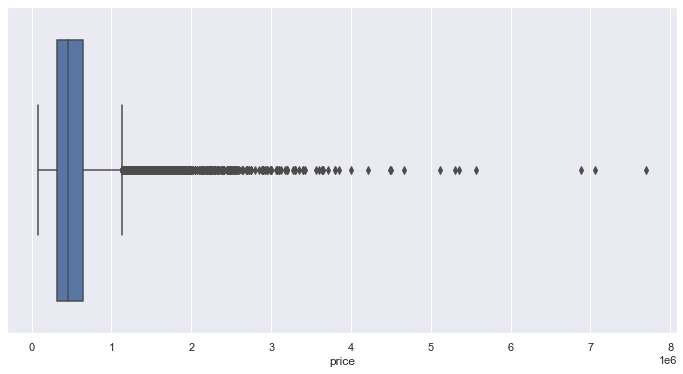

In [18]:
sns.boxplot(data=num_attributes, x='price');

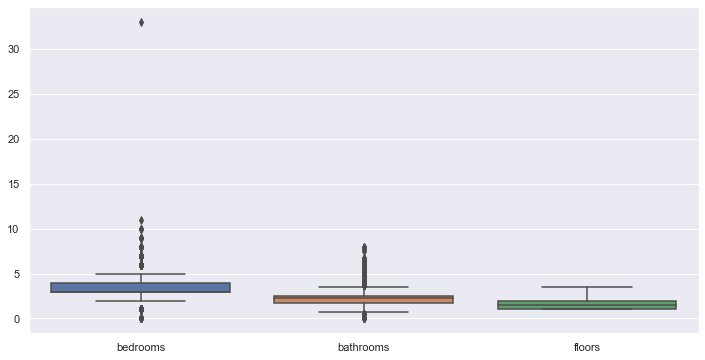

In [19]:
sns.boxplot(data=num_attributes[['bedrooms', 'bathrooms','floors']]);

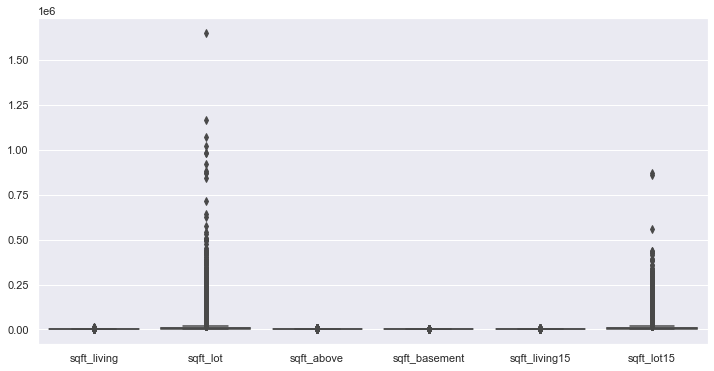

In [20]:
sns.boxplot(data=num_attributes[[ 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']]);

Outliers:
- price      > 5e6
- bedrooms   > 15
- sqft_lot   > .75e6
- sqft_lot15 > .5e6

#### 1.1.5.2. Atributos de Tempo

In [22]:
time_attributes.head()

date
0 2014-10-13
1 2014-12-09
2 2015-02-25
3 2014-12-09
4 2015-02-18

##### 1.1.5.2.1. Medidas de Tendência Central e Dispersão

In [23]:
# min, quartiles (Q1: 25%, Q2: 50%, Q3: 75%), max
attri1 = time_attributes.describe(datetime_is_numeric=True).drop(['count', 'mean'], axis=0)

# range                                                                         
attri2 = time_attributes.agg(['ptp']).rename(index={'ptp': 'range'})

# unique, top, freq
attri3 = time_attributes.describe().drop(['count', 'first', 'last'], axis=0)

# concatenate
pd.concat([attri1, attri2, attri3], axis=0).T

min        25%        50%        75%        max    range unique        top freq
date 2014-05-02 2014-07-22 2014-10-16 2015-02-17 2015-05-27 390 days    372 2014-06-23  142

#### 1.1.5.3. Atributos Categóricos

In [ ]:
cat_attributes.head()

## 1.2. ENGENHARIA DE FEATURES

In [26]:
df2 = df1.copy()

In [27]:
# criar variável year
df2 = get_year(df2, 'date')

# criar variável house_age - Idade
df2 = get_house_age(df2, 20)

# criar variável cond_type - Conservação
df2 = get_cond_type(df2)

# criar variável level of construction and design - Qualidade do imóvel - house_quality
df2 = get_house_quality(df2)

# criar variável distance - Localização
df2 = get_distance_km(df2, (47.606209, -122.332069))

# criar variável level - faixa de custo
df2 = get_level(df2)

# criar variável month
df2 = get_year_month(df2)

# criar variável basement
df2 = get_basement(df2)

# transformar valores da variável waterfront
df2 = get_waterfront(df2)

# criar variável dormitory_type
df2 = get_dormitory_type(df2)

## 1.3. FILTRAGEM DE VARIÁVEIS

In [28]:
df3 = df2.copy()

### 1.3.1. Filtragem de Linhas

#### 1.3.1.1. IDs Duplicados

In [29]:
# identificar colunas com valores diferentes com o mesmo ID
identify_cols(df1, 'id')

Coluna com valores diferentes, para duplicações da coluna id: date.
Coluna com valores diferentes, para duplicações da coluna id: price.


In [30]:
# apagar IDs duplicados e desatualizados
df3 = rm_dup(df3, 'id')

In [32]:
# dimensões do dataset
print('Número de linhas: {}'.format(df3.shape[0]))
print('Número de colunas: {}'.format(df3.shape[1]))

Number of Rows: 21436
Number of Cols: 30


#### 1.3.1.2. Outliers

In [33]:
# filtragem de preços
df3 = df3[df3['price'] <= 5e6]

# filtragem de quartos
df3 = df3[df3['bedrooms'] <= 15]

# filtragem da área de loteamento
df3 = df3[df3['sqft_lot'] <= .75e6]

# filtragem do sqft_lot15
df3 = df3[df3['sqft_lot15'] <= .5e6]

In [34]:
# dimensões do dataset
print('Número de linhas: {}'.format(df3.shape[0]))
print('Número de colunas: {}'.format(df3.shape[1]))

Number of Rows: 21416
Number of Cols: 30


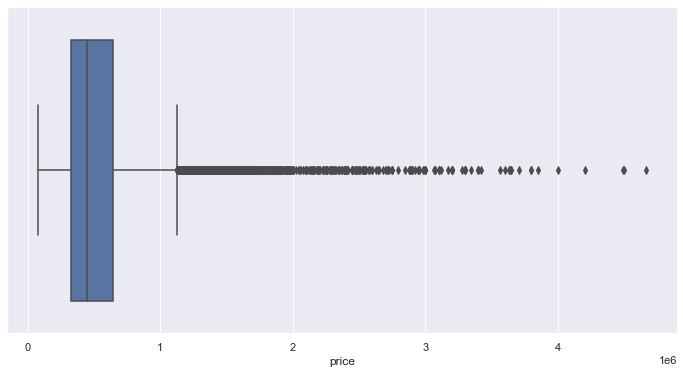

In [35]:
sns.boxplot(data=df3, x='price');

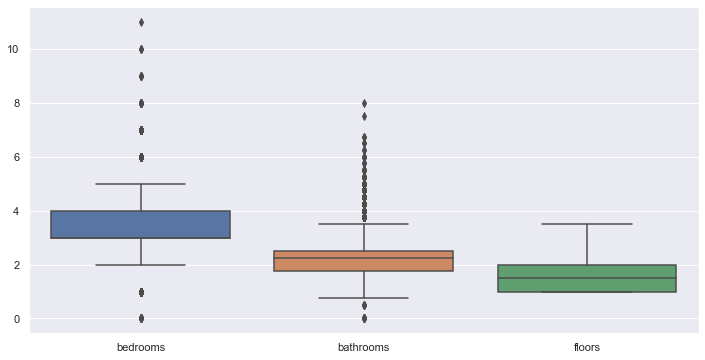

In [36]:
sns.boxplot(data=df3[['bedrooms', 'bathrooms','floors']]);

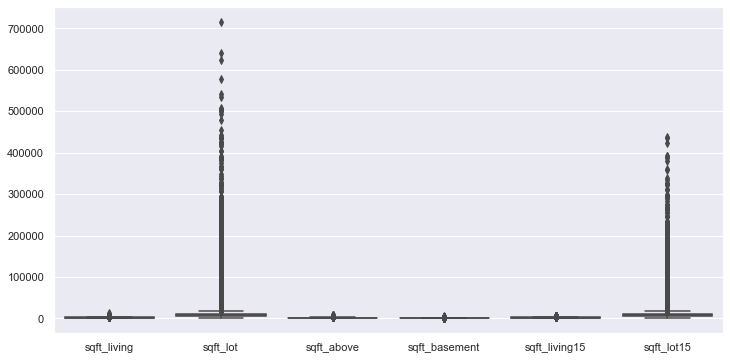

In [37]:
sns.boxplot(data=df3[[ 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15']]);

# 2.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [38]:
df4 = df3.copy()

## 2.1. Formulação de Hipóteses

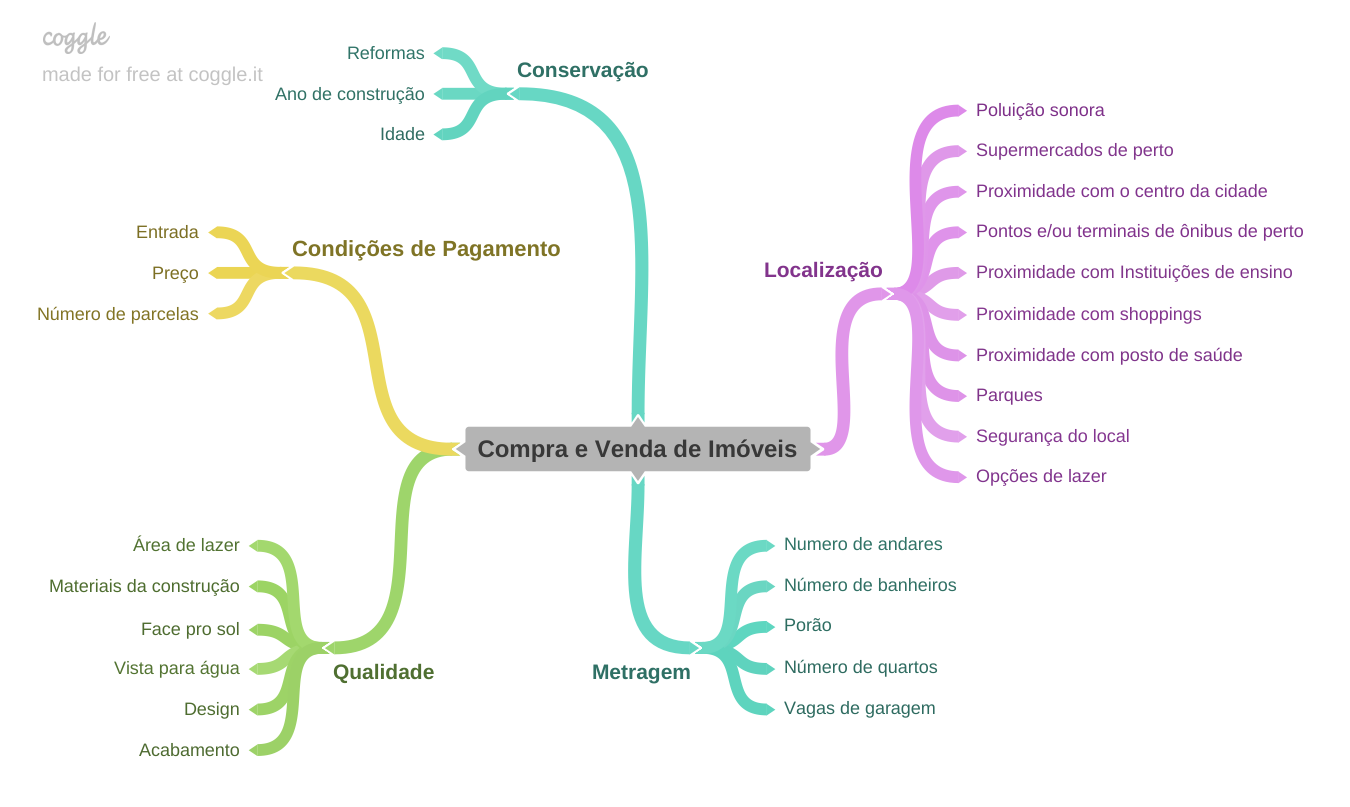

In [39]:
Image('img/mindmap.png')

### Hipóteses de Negócio

1. Os imóveis mais novos deveriam ser um 20% mais caros, na média, que os antigos.
2. Os imóveis em boas condições deveriam ser 20% mais caros, na média, que os imóveis em condições regulares.
3. Os imóveis mais novos que estão em boas condições deveriam ser 30% mais caros, na média, que os imóveis antigos em condições  regulares.
4. Imóveis novos e em boas condições são 70% mais ofertados que imóveis antigos e em condições regulares.
5. Imóveis de 3 quartos com reforma para ter mais um, se valorizam em 30%, na média.
6. Imóveis próximos do centro da cidade deveriam ser um 30% mais caros, na média, dos que estão mais afastados.
7. Um imóvel de qualidade média deveria ser 40% mais barato que um de qualidade alta
8. A valorização dos imóveis com reforma de banheiros (completos) para ter mais um, cresce um 10%, na média.
9. Imóveis com porão são 40% mais caros, na média, do que os imóveis sem porão.
10. Imóveis que possuem vista para água, são 30% mais caros, na média.

## 2.2. Validação das Hipóteses

### Os imóveis mais novos deveriam ser um 20% mais caros, na média, que os antigos.

***Hipótese verdadeira***

Os imóveis mais novos são 20% mais caros, na média, que os antigos.

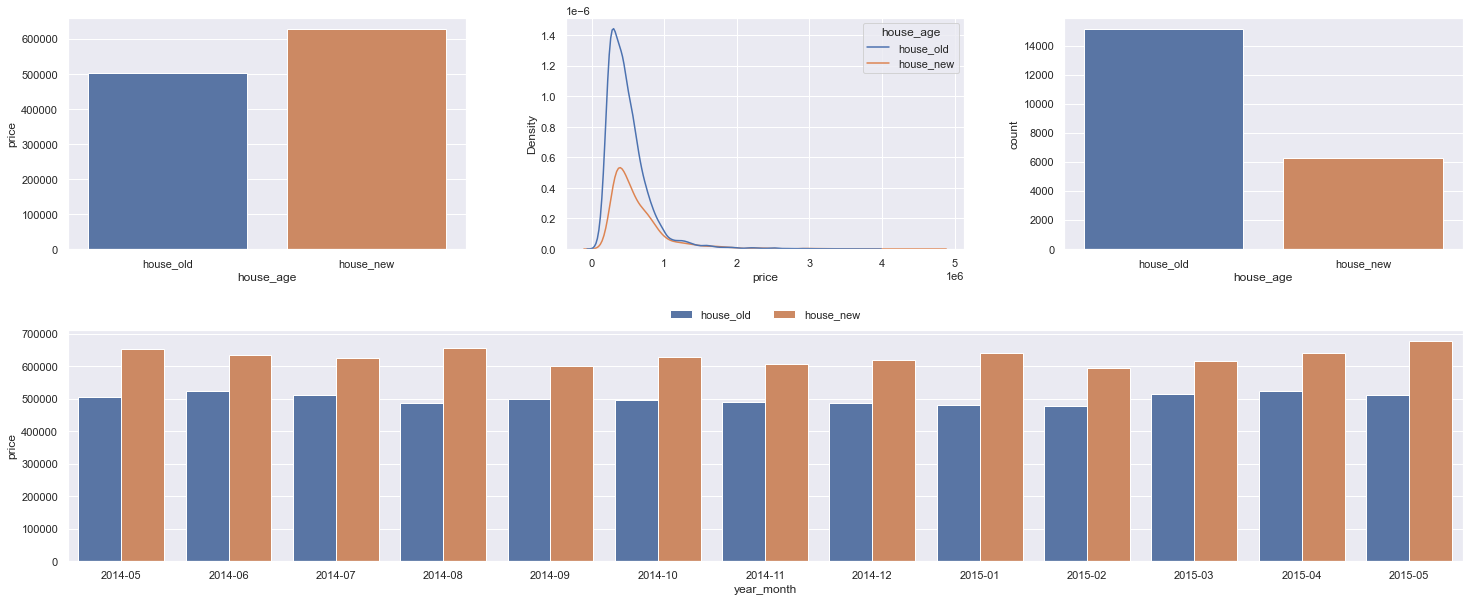

In [40]:
# ----------
# Parametros
# ----------

# size fig. parameters
w_size = 25
h_size = 10

# plot separation parameters
w_space = .25
h_space = .35

# -----
# Plots
# -----

fig = plt.figure()

# Set matrix size and plot separations
gs = gridspec.GridSpec(2, 3, wspace=w_space, hspace=h_space)

fig.add_subplot(gs[0, 0])
# price vs house_age
by_house_age = df4[['house_age', 'price']].groupby('house_age').mean().reset_index()
sns.barplot(data=by_house_age, x='house_age', y='price', order=['house_old', 'house_new'])

fig.add_subplot(gs[0, 1])
# Probability density plot
sns.kdeplot( data=df4, x='price', hue='house_age')

fig.add_subplot(gs[0, 2])
# Categorical bar plot
sns.countplot( data=df4, x='house_age' );

fig.add_subplot(gs[1, :])
# Agrupar por mes e idade
var_tmp = df4[['year_month', 'house_age', 'price']].groupby(['year_month', 'house_age']).mean().reset_index()
# Plot de barras
ax=sns.barplot(data=var_tmp, x='year_month', y='price', hue='house_age', hue_order=['house_old', 'house_new']);
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

# Set figure size
ax.figure.set_size_inches(w_size, h_size)
fig.align_labels()

In [41]:
# Preço imóveis antigos
price_old = df4.loc[df4['house_age'] == 'house_old', 'price'].mean()

# Preço imóveis novos
price_new = df4.loc[df4['house_age'] == 'house_new', 'price'].mean()

# Percentual do preço
print(f'Os imóveis novos são {(price_new - price_old)*100/price_new:.0f}% mais caros.')

Os imóveis novos são 20% mais caros.


In [42]:
# Agrupar por mes e idade
var_tmp = df4[['year_month', 'house_age', 'price']].groupby(['year_month', 'house_age']).mean().reset_index()

# Criar variável valorização
var_tmp['diff'] = var_tmp['price'].diff()
var_tmp['appreciation_%'] = 0
for i in range(len(var_tmp)-1):
    var_tmp.loc[i+1, 'appreciation_%'] = -var_tmp.loc[i+1, 'diff']*100/var_tmp.loc[i, 'price']

# Valorização por mes
var_tmp.loc[var_tmp['appreciation_%'] > 0, ['year_month', 'appreciation_%']]

year_month  appreciation_%
1     2014-05           22.74
3     2014-06           17.50
5     2014-07           18.30
7     2014-08           25.70
9     2014-09           17.04
11    2014-10           21.30
13    2014-11           19.25
15    2014-12           21.13
17    2015-01           24.87
19    2015-02           19.56
21    2015-03           16.10
23    2015-04           18.35
25    2015-05           24.42

In [43]:
# Imóveis mais novos são 20% mais caros, na média, que os antigos. Hipótese verdadeira. 
# Ao longo do tempo imóveis mais novos são até 25,7% mais caros (agosto).

# Acionáveis: 

# 1. Compra imóveis antigos. São mais baratos.
# 2. Os imóveis antigos se reformados para ficar como novos, se valorizam em um 20%. Logo, compra imóveis antigos e reforma. 

### Os imóveis em boas condições deveriam ser 20% mais caros, na média, que os imóveis em condições regulares.

***Hipótese falsa***

Os imóveis em boas e regulares condições tem, na média, o mesmo preço.

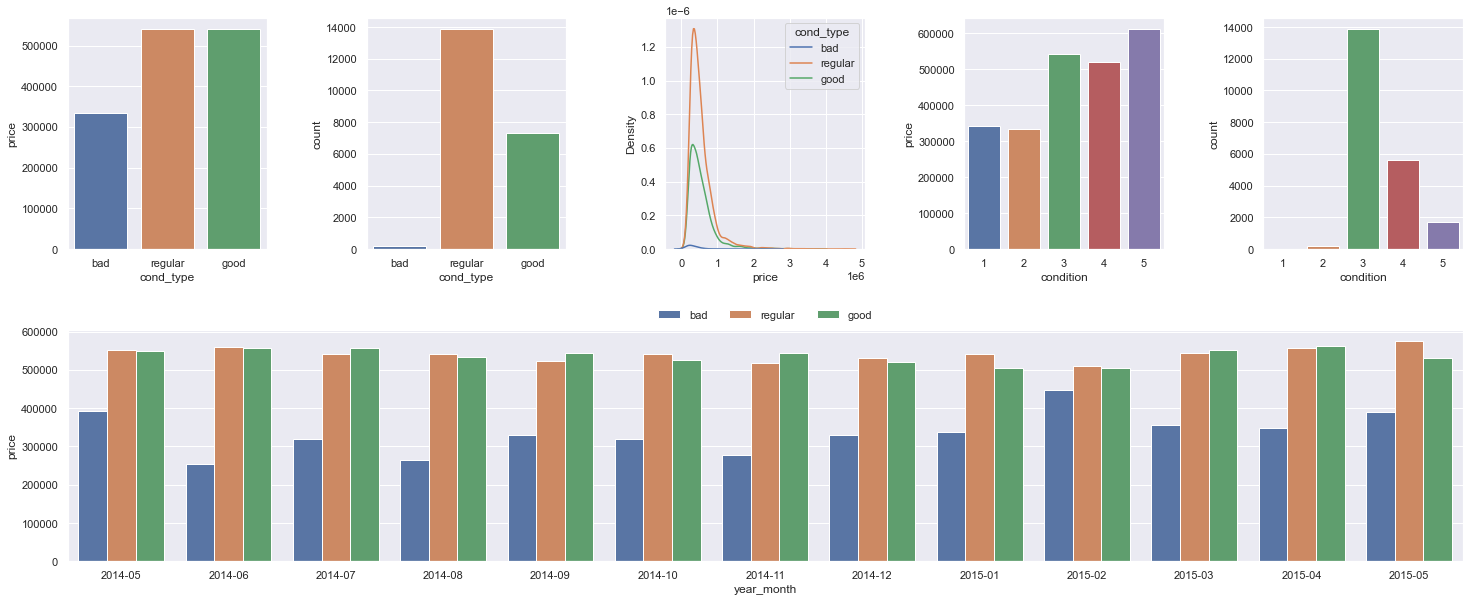

In [44]:
# ----------
# Parâmetros
# ----------

# Tamanho fig.
w_size = 25
h_size = 10

# Separation parameters
w_space = .5
h_space = .35

# -----
# Plots
# -----

fig = plt.figure()

# Set matrix size and plot separations
gs = gridspec.GridSpec(2, 5, wspace=w_space, hspace=h_space)

fig.add_subplot(gs[0, 0])
by_cond_type = df4[['price', 'cond_type']].groupby('cond_type').mean().reset_index()
sns.barplot(data=by_cond_type, x='cond_type', y='price', order=['bad', 'regular', 'good']);

fig.add_subplot(gs[0, 1])
sns.countplot( data=df4, x='cond_type', order=['bad', 'regular', 'good'])

fig.add_subplot(gs[0, 2])
sns.kdeplot( data=df4, x='price', hue='cond_type', hue_order=['bad', 'regular', 'good']);

fig.add_subplot(gs[0, 3])
by_cond = df4[['price', 'condition']].groupby('condition').mean().reset_index()
sns.barplot(data=by_cond, x='condition', y='price');

fig.add_subplot(gs[0, 4])
sns.countplot( data=df4, x='condition', order=[1, 2, 3, 4, 5])

fig.add_subplot(gs[1, :])
by_yr_m_s = df4[['year_month', 'cond_type', 'price']].groupby(['year_month', 'cond_type']).mean().reset_index()
ax = sns.barplot(data=by_yr_m_s, x='year_month', y='price', hue='cond_type', hue_order=['bad', 'regular', 'good']);
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

# Set figure size
ax.figure.set_size_inches(w_size, h_size)
fig.align_labels()

In [45]:
by_cond = df4[['price', 'cond_type']].groupby('cond_type').mean().reset_index()
by_cond = by_cond.T.loc[:,[0,2,1]].T.reset_index(drop=True)
by_cond

cond_type     price
0       bad 335152.81
1   regular 541435.37
2      good 541410.20

In [46]:
# Hipótese falsa. Os imóveis em boas e regulares condições tem, na média, praticamente o mesmo preço.
# Em alguns meses o preço dos imóveis em boas condições é, visívelmente, maior que o preço dos imóveis em condições regulares.

# Acionáveis: 

# 1. Como os preços, na média, são os mesmos é mais conveniente comprar imóveis em boas condições. E, revendé-los.
# 2. Imóveis em condições regulares (condition = 3) se reformados para ficar em boas condições (condition = 5), podem se valorizar em 13%. Logo, compra imóveis em condições regulares, reforma, e vende mais caro.

# Motivo do resultado:

# O preço dos imóveis em boas condições é calculado como a média dos preços das condições 4 e 5. Porém, a condição 4, que tem um preço menor que a condição 5, tem um peso maior no cálculo do preço médio devido à alta quantidade de imóveis deste tipo. Ver figuras no dashboard.

### <span class="burk">Os imóveis mais novos que estão em boas condições deveriam ser 30% mais caros, na média, que os imóveis antigos em condições  regulares.</span> 

***Hipótese verdadeira*** 

Os imóveis house_new_good são 60% mais caros, na média, que os imóveis house_old_regular.

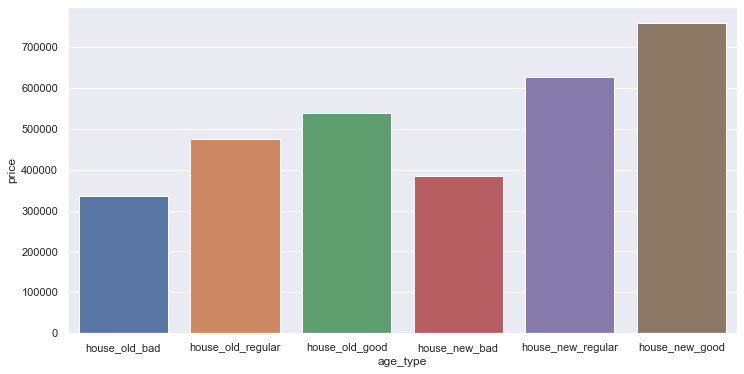

In [47]:
by_age_cond = df4[['cond_type','house_age','price']].groupby(['house_age', 'cond_type']).mean().reset_index()
by_age_cond['age_type'] = by_age_cond['house_age'] + '_' + by_age_cond['cond_type']
sns.barplot(data=by_age_cond, x='age_type', y='price', order=['house_old_bad', 'house_old_regular', 'house_old_good', 'house_new_bad', 'house_new_regular', 'house_new_good']);

#### appreciation

#####  house_new_regular > house_new_good

In [48]:
# Preço de um imóvel house_new e good
price_ref = get_price_age_cond(df4, 'house_new', 'good', 1)

# Preço de um imóvel house_old e regular
price     = get_price_age_cond(df4, 'house_new', 'regular', 1)

# Imprimir valorização
print(f'Valorização: {(price_ref - price)*100/price:.0f}%.')

Percentual de imóveis house_new - good: 0.6%.
Preço médio: 759566.6.

Percentual de imóveis house_new - regular: 28.6%.
Preço médio: 626864.3.

Valorização: 21%.


##### house_old_good > house_new_good

In [49]:
# Preço de um imóvel house_new e good
price_ref = get_price_age_cond(df4, 'house_new', 'good', 1)

# Preço de um imóvel house_old e regular
price     = get_price_age_cond(df4, 'house_old', 'good', 1)

# Imprimir valorização
print(f'Valorização: {(price_ref - price)*100/price:.0f}%.')

Percentual de imóveis house_new - good: 0.6%.
Preço médio: 759566.6.

Percentual de imóveis house_old - good: 33.6%.
Preço médio: 537715.7.

Valorização: 41%.


##### house_old_regular > house_new_good

In [50]:
# Preço de um imóvel house_new e good
price_ref = get_price_age_cond(df4, 'house_new', 'good', 1)

# Preço de um imóvel house_old e regular
price     = get_price_age_cond(df4, 'house_old', 'regular', 1)

# Imprimir valorização
print(f'Valorização: {(price_ref - price)*100/price:.0f}%.')

Percentual de imóveis house_new - good: 0.6%.
Preço médio: 759566.6.

Percentual de imóveis house_old - regular: 36.3%.
Preço médio: 474236.6.

Valorização: 60%.


#### Resumo

In [51]:
# hipótese verdadeira. Os imóveis house_new_good são 60% mais caros que os imóveis house_old_regular. 

# Acionáveis:

# 1. Imóveis antigos e em condições regulares se reformados se valorizam em 60%. Logo, compra imóveis house_old_regular e reforma.
# 2. Imóveis antigos e em condições boas      se reformados se valorizam em 41%. Logo, compra imóveis house_old_good    e reforma.
# 3. Imóveis novos   e em condições regulares se reformados se valorizam em 21%. Logo, compra imóveis house_new_regular e reforma.

#### price vs month

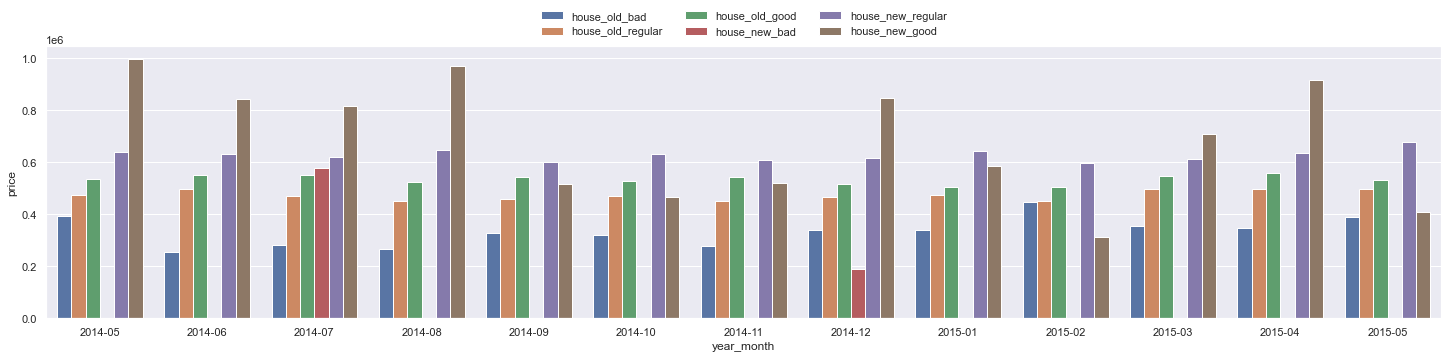

In [52]:
by_age_cond = df4[['year_month', 'cond_type','house_age','price']].groupby(['year_month', 'house_age', 'cond_type']).mean().reset_index()
by_age_cond['age_type'] = by_age_cond['house_age'] + '_' + by_age_cond['cond_type'] 
ax=sns.barplot(data=by_age_cond, x='year_month', y='price', hue='age_type', hue_order=['house_old_bad', 'house_old_regular', 'house_old_good', 'house_new_bad', 'house_new_regular', 'house_new_good']);
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.figure.set_size_inches(25, 5)

In [53]:
var1 = by_age_cond.loc[by_age_cond['age_type'] == 'house_new_good',['year_month', 'price']].sort_values('year_month', ascending=True)
var2 = by_age_cond.loc[by_age_cond['age_type'] == 'house_old_regular',['year_month', 'price']].sort_values('year_month', ascending=True)
merge_var = pd.merge(var1, var2, how='inner', on='year_month')
merge_var['appre_%'] = merge_var.apply(lambda x: (x['price_x']/x['price_y']-1)*100, axis=1)
merge_var.columns = ['year_month','price_new_good','price_old_reg','appre_%']
merge_var

year_month  price_new_good  price_old_reg  appre_%
0     2014-05       996316.67      472592.87   110.82
1     2014-06       843999.91      496143.27    70.11
2     2014-07       817141.00      470968.17    73.50
3     2014-08       972625.00      452027.42   115.17
4     2014-09       516670.83      458680.68    12.64
5     2014-10       465136.36      468813.25    -0.78
6     2014-11       522333.33      451957.05    15.57
7     2014-12       846928.57      466271.02    81.64
8     2015-01       585800.00      472603.13    23.95
9     2015-02       311987.50      453049.49   -31.14
10    2015-03       707300.50      496730.69    42.39
11    2015-04       915492.86      497518.44    84.01
12    2015-05       410000.00      496717.81   -17.46

In [54]:
# Hipótese não validada. Em alguns meses os imóveis house_new_good são mais baratos que os imóveis house_old_reg. Em agosto os imóveis house_old_reg podem se valorizar em 115% se reformados. Possível insight.

# Acionáveis:

# 1. Compra imóveis house_new_good em fevereiro e revende nos meses mais caros.

### <span class="burk">Imóveis novos e em boas condições são 70% mais ofertados que imóveis antigos e em condições regulares.</span>

***Hipótese falsa***

Por cada imóvel novo em boas condições temos, aproximadamente, 64 imóveis antigos em condições regulares ofertados.

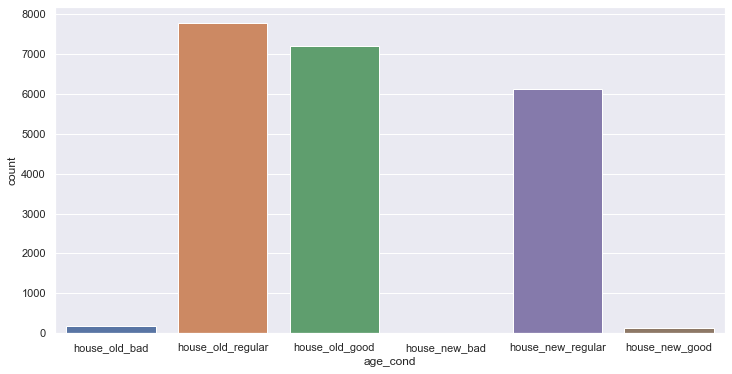

In [55]:
by_age_cond = df4[['cond_type','house_age','id']].groupby(['house_age', 'cond_type']).count().reset_index()
by_age_cond['age_cond'] = by_age_cond['house_age'] + '_' + by_age_cond['cond_type']
by_age_cond.columns = ['house_age', 'cond_type', 'count', 'age_cond']
sns.barplot(data=by_age_cond, x='age_cond', y='count', order=['house_old_bad', 'house_old_regular', 'house_old_good', 'house_new_bad', 'house_new_regular', 'house_new_good']);

In [56]:
by_age_cond

house_age cond_type  count           age_cond
0  house_new       bad      2      house_new_bad
1  house_new      good    122     house_new_good
2  house_new   regular   6119  house_new_regular
3  house_old       bad    190      house_old_bad
4  house_old      good   7204     house_old_good
5  house_old   regular   7779  house_old_regular

In [57]:
# Só 122, imóveis novos e em boas condições, de cada 7779, imóveis antigos em condições regulares, são ofertados. A hipotese é falsa. A informação surpreende em vista que se mostra é o contrário, que são os imóveis house_old_reg os que são mais ofertados que os house_new_good. Possível insight.

# Acionáveis:

# 1. Compra imóveis house_old_reg, house_old_good e house_new_regular, reforma, e vende mais caro.

# Motivo do resultado:

# Um dos motivos seria que os imóveis house_old_reg são mais baratos que os house_new_good (Ver hipótese validada 5.2.3). Porém, a queda da oferta nos imóveis house_new_good é muito drástica como para ser justificada somente pelo preço.

#### count vs month

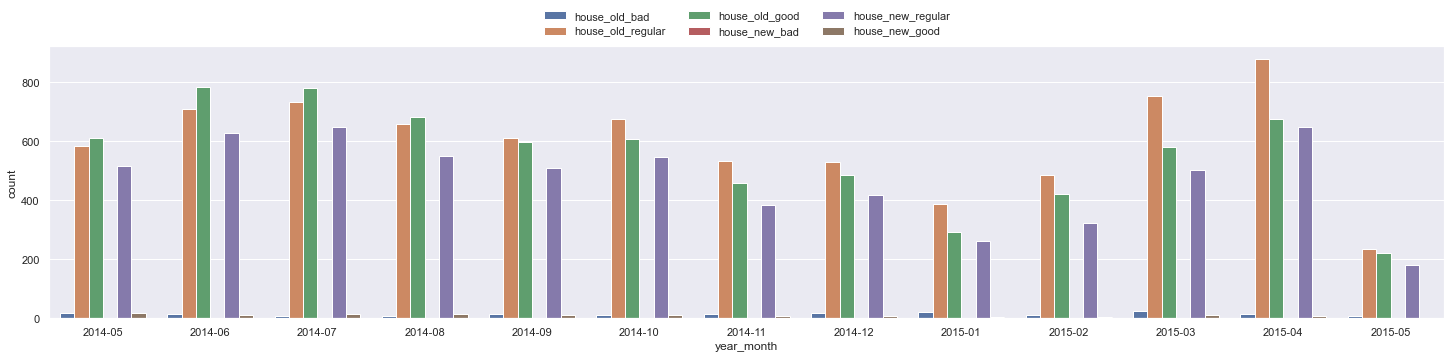

In [58]:
by_age_cond = df4[['year_month', 'cond_type','house_age','id']].groupby(['year_month', 'house_age', 'cond_type']).count().reset_index()
by_age_cond.columns = ['year_month', 'house_age','cond_type','count']
by_age_cond['age_cond'] = by_age_cond['house_age'] + '_' + by_age_cond['cond_type'] 
ax=sns.barplot(data=by_age_cond, x='year_month', y='count', hue='age_cond', hue_order=['house_old_bad', 'house_old_regular', 'house_old_good', 'house_new_bad', 'house_new_regular', 'house_new_good']);
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)
ax.figure.set_size_inches(25, 5)

In [59]:
# Hipótese se mentêm falsa mes-a-mes.

### <span class="burk">Imóveis de 3 quartos com reforma para ter mais um, se valorizam em 30%, na média.</span>

***Hipótese verdadeira***

Imóveis de 3 quartos com reforma para ter mais um, se valorizam em 36%, na média.

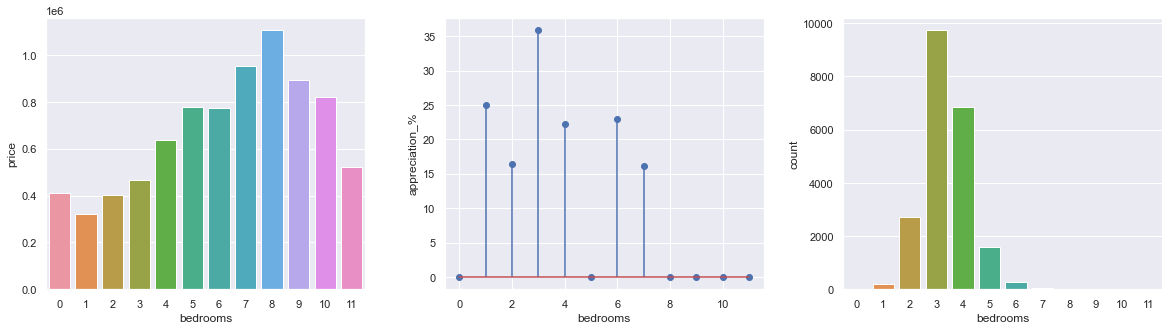

In [60]:
# Parametros:

# size fig. parameters
w_size = 20
h_size = 5

# plot separation parameters
w_space = .25
h_space = .35

# -----
# Plots
# -----

# Criar variável de preço médio por imóvel segundo número de quartos
by_bedrooms = df4[['bedrooms', 'price']].groupby('bedrooms').mean().reset_index()
by_bedrooms['price_per_bed'] = by_bedrooms['price'].diff()

# Cria variável de valorização do imóvel se reformado para ter mais um quarto
by_bedrooms['appreciation_%'] = 0 # imóvel não valorizado
for i in range(len(by_bedrooms) - 1):
    if by_bedrooms.loc[i + 1, 'price_per_bed'] > 0:
        by_bedrooms.loc[i, 'appreciation_%'] = by_bedrooms.loc[i + 1, 'price_per_bed'] * 100 / by_bedrooms.loc[i, 'price']

# Apagar coluna price_per_bed
by_bedrooms.drop('price_per_bed', axis=1, inplace=True)

# Núero de imóveis com um dado número de quartos
by_count = df4[['bedrooms', 'id']].groupby('bedrooms').count().reset_index()
by_count.columns = ['bedrooms', 'count']

# Juntar dataframes
by_merge = pd.merge(by_bedrooms, by_count, how='inner', on='bedrooms')
by_merge = by_merge.loc[:,['count','bedrooms','price','appreciation_%']]

# -----
# Plots
# -----

fig = plt.figure()

# Set matrix size and plot separations
gs = gridspec.GridSpec(1, 3, wspace=w_space, hspace=h_space)

fig.add_subplot(gs[0, 0])
ax=sns.barplot(data=by_merge, x='bedrooms', y='price')

fig.add_subplot(gs[0, 1])
plt.stem(by_merge['bedrooms'], by_merge['appreciation_%']);
plt.xlabel('bedrooms')
plt.ylabel('appreciation_%')

fig.add_subplot(gs[0, 2])
sns.barplot(data=by_count, x='bedrooms', y='count');

# Set figure size
ax.figure.set_size_inches(w_size, h_size)
fig.align_labels()

In [61]:
by_merge

count  bedrooms      price  appreciation_%
0      13         0  409503.85            0.00
1     194         1  321180.07           25.03
2    2733         2  401582.25           16.47
3    9729         3  467709.25           35.93
4    6843         4  635743.88           22.20
5    1581         5  776901.46            0.00
6     262         6  773128.29           23.03
7      38         7  951184.66           16.18
8      13         8 1105076.92            0.00
9       6         9  893999.83            0.00
10      3        10  819333.33            0.00
11      1        11  520000.00            0.00

In [62]:
# Hipótese verdadeira. 

# Acionáveis: 

# 1. Compra imóveis com 3 quartos e com potencial de reforma. Se valorizam 36% se aumentarmos o número de quartos em mais um.

### <span class="burk">Imóveis próximos do centro da cidade deveriam ser um 30% mais caros, na média, dos que estão mais afastados.</span>

***Hipótese verdadeira*** 

Imóveis próximos do centro da cidade são 46% mais caros, na média, dos que estão mais afastados.

In [63]:
# =============================================================
# Local onde se concentram a grande maioria de imóveis: Seattle
# =============================================================

# Dados a graficar no mapa
houses = df4[['id','lat','long','level','price']]

fig = px.scatter_mapbox(houses, 
                         lat= 'lat',
                         lon= 'long', 
                         size= 'price',
                         color= 'level',
                         color_discrete_map={
                             "low": "blue",
                             "avg": "red",
                             "high": "black"},
                         category_orders={"level": ["low", "avg", "high"]},
                         # color_continuous_scale=px.colors.sequential.Blackbody_r, 
                         size_max=15, 
                         zoom=10)

fig.update_layout(mapbox_style='open-street-map')
fig.update_layout(height=600, margin={'r':0, 't':0, 'l':0, 'b':0})
fig.show()

In [64]:
# Os imóveis se concentram ao redor do Seattle.

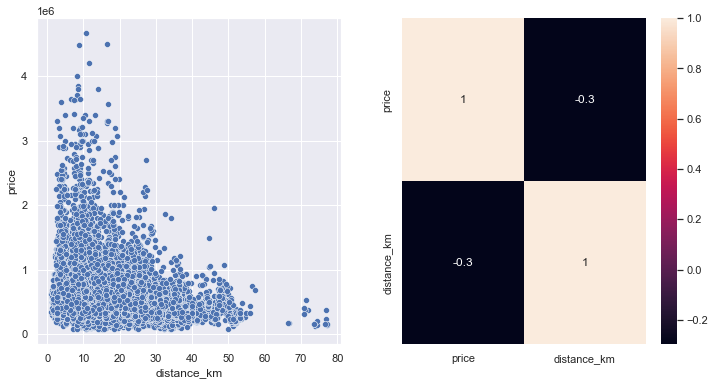

In [65]:
plt.subplot(1,2,1)
# distance vs price
sns.scatterplot(x='distance_km', y='price', data=df4);

plt.subplot(1,2,2)
# correlation
sns.heatmap( df4[['price', 'distance_km']].corr( method='pearson' ), annot=True );

In [66]:
# Imóveis próximos do centro da cidade tendem a ser mais caros. Se observa uma alta correlação (-0.3) entre price e distance_km. O sinal negativo reforça a relação inversa entre as variáveis.

In [67]:
# Raio da região central da cidade
dis_max = 5.0 
# OBS: Vamos supor que os imóveis que se encontram dentro deste raio estão no centro da cidade

# Preço dos imóveis no centro
price_down = df4.loc[df4['distance_km'] <= dis_max, 'price'].mean()

# preço dos imóveis fora do centro
price_up   = df4.loc[df4['distance_km']  > dis_max, 'price'].mean()

# Percentual da diferença de preço
print(f'O preço dos imóveis no centro da cidade é {(price_down/price_up-1)*100:.0f}% maior, na média.')

O preço dos imóveis no centro da cidade é 46% maior, na média.


In [68]:
# Hipótese verdadeira. 

# Acionáveis: 

# 1. Compra imóveis mais afastados do centro da cidade. São mais baratos. 
# 2. Compra imóveis no centro da cidade. Porém, abaixo do preço do mercado (média ou mediana) dessa região. Em vista que se observam imóveis com uma ampla faixa de preços (ver scatterplot). Esta nova informação surpreende. Possível insight.

### Um imóvel de qualidade média deveria ser 40% mais barato que um de qualidade alta.

***Hipótese verdadeira***

Um imóvel de qualidade média é 61% mais barato que um de qualidade alta.

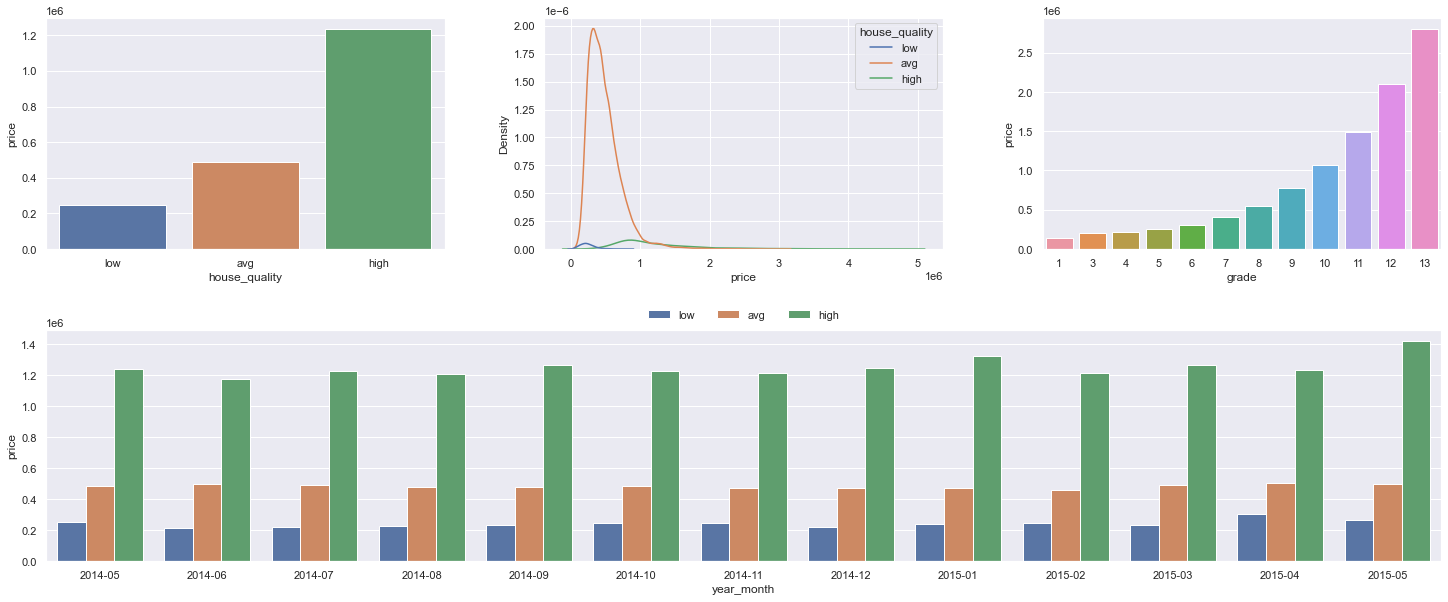

In [69]:
# parametros:

# size fig. parameters
w_size = 25
h_size = 10

# plot separation parameters
w_space = .25
h_space = .35

# plots

fig = plt.figure()

# Set matrix size and plot separations
gs = gridspec.GridSpec(2, 3, wspace=w_space, hspace=h_space)

fig.add_subplot(gs[0, 0])
by_quality = df4[['house_quality', 'price']].groupby('house_quality').mean().reset_index()
sns.barplot(data=by_quality, x='house_quality', y='price', order=['low','avg','high']);

fig.add_subplot(gs[0, 1])
sns.kdeplot( data=df4, x='price', hue='house_quality', hue_order=['low', 'avg', 'high']);

fig.add_subplot(gs[0, 2])
by_zip = df4[['price','grade']].groupby('grade').mean().reset_index()
sns.barplot(x='grade', y='price', data=by_zip);

fig.add_subplot(gs[1, :])
by_yr_m_s = df4[['year_month', 'house_quality', 'price']].groupby(['year_month', 'house_quality']).mean().reset_index()
ax = sns.barplot(data=by_yr_m_s, x='year_month', y='price', hue='house_quality', hue_order=['low', 'avg', 'high']);
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

# Set figure size
ax.figure.set_size_inches(w_size, h_size)
fig.align_labels()

In [70]:
by_yr_m_s = df4[['year_month', 'house_quality', 'price']].groupby(['year_month', 'house_quality']).mean().reset_index()
var1 = by_yr_m_s.loc[by_yr_m_s['house_quality'] == 'high', ['year_month', 'price']].sort_values('year_month', ascending=True)
var2 = by_yr_m_s.loc[by_yr_m_s['house_quality'] == 'avg', ['year_month', 'price']].sort_values('year_month', ascending=True)
merge_var = pd.merge(var1,var2,how='inner',on='year_month')
merge_var.columns = ['year_month','price_high', 'price_avg']
merge_var['appre_%'] = merge_var.apply(lambda x: (1-x['price_avg']/x['price_high'])*100, axis=1)
merge_var

year_month  price_high  price_avg  appre_%
0     2014-05  1238590.59  484652.50    60.87
1     2014-06  1179563.45  497575.53    57.82
2     2014-07  1226119.90  493542.28    59.75
3     2014-08  1207606.37  477478.16    60.46
4     2014-09  1268538.78  481844.15    62.02
5     2014-10  1226745.24  484962.93    60.47
6     2014-11  1218003.39  472222.62    61.23
7     2014-12  1249224.56  470235.81    62.36
8     2015-01  1324177.31  470605.56    64.46
9     2015-02  1216144.10  461148.76    62.08
10    2015-03  1268638.41  495400.57    60.95
11    2015-04  1233728.25  508270.19    58.80
12    2015-05  1422567.20  496147.08    65.12

In [71]:
# Preço qualidade alta
price_high = df4.loc[df4['house_quality'] == 'high','price'].mean()

# Preço qualidade média
price_avg  = df4.loc[df4['house_quality'] ==  'avg','price'].mean()

print(f'Um imóvel de qualidade média é {(1-price_avg/price_high)*100:.0f}% mais barato.')

Um imóvel de qualidade média é 61% mais barato.


In [72]:
# Hipótese falsa. 

# Acionáveis: 

# 1. Compra imóveis house_avg. A informação surpreende em vista da grande diferença entre o valor achado e o dado pelas novas informações. Possivel insigh.

In [73]:
# Número de imóveis com qualidade alta
num_ids_high = df4.loc[df4['house_quality'] == 'high','id'].count()

# Número de imóveis com qualidade média
num_ids_avg  = df4.loc[df4['house_quality'] == 'avg','id'].count()

print(f'Percentual de imóveis de qualidade alta: {num_ids_high*100/df4.shape[0]:.0f}%.')
print(f'Percentual de imóveis de qualidade média: {num_ids_avg*100/df4.shape[0]:.0f}%.')

Percentual de imóveis de qualidade alta: 8%.
Percentual de imóveis de qualidade média: 91%.


### A valorização dos imóveis com reforma de banheiros (completos) para ter mais um, cresce um 10%, na média.

***Hipótese verdadeira***

A valorização dos imóveis com reforma de banheiros (completos) para ter mais um, cresce, no mínimo, um 16,6%, na média.

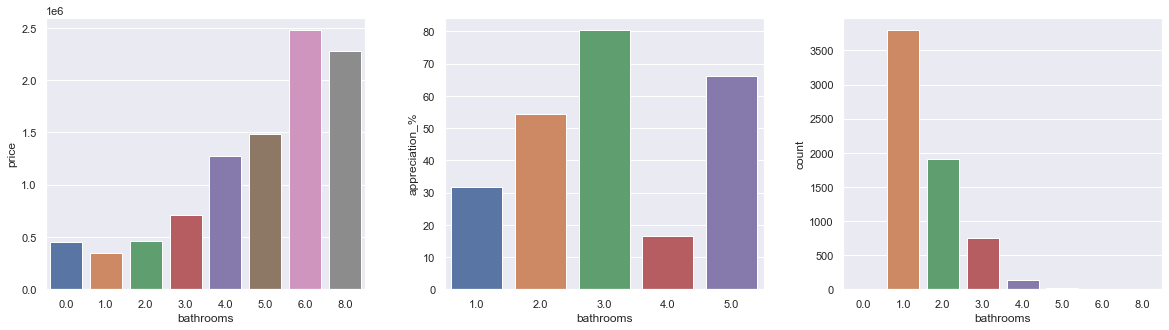

In [74]:
# size fig. parameters
w_size = 20
h_size = 5

# plot separation parameters
w_space = .25
h_space = .35

by_bath = df4[['price', 'bathrooms']].groupby('bathrooms').mean().reset_index()
by_bath = by_bath[(by_bath['bathrooms'] % 2 == 1) | (by_bath['bathrooms'] % 2 == 0)].reset_index().drop('index',axis=1)
by_bath['price_per_bath'] = by_bath['price'].diff()

by_bath['tmp'] = 0
for ind in range(len(by_bath)):
    by_bath.loc[ind+1,'tmp'] = by_bath.loc[ind,'price']
by_bath['appreciation_%'] = by_bath.apply(lambda x: x['price_per_bath']*100/x['tmp'], axis=1)
by_bath.drop('tmp',axis=1,inplace=True)

for ind in range(len(by_bath)):
    if ind < len(by_bath)-1:
        by_bath.loc[ind,'appreciation_%'] = by_bath.loc[ind+1,'appreciation_%']

# Imóveis com um dado número de quartos
by_count = df4[['bathrooms', 'id']].groupby('bathrooms').count().reset_index()
by_count = by_count[(by_count['bathrooms'] % 2 == 1) | (by_count['bathrooms'] % 2 == 0)].reset_index().drop('index',axis=1)
by_count.columns = ['bathrooms', 'count']

# Juntar dataframes
by_merge = pd.merge(by_bath, by_count, how='inner', on='bathrooms')

# -----
# Plots
# -----

fig = plt.figure()

# Set matrix size and plot separations
gs = gridspec.GridSpec(1, 3, wspace=w_space, hspace=h_space)

fig.add_subplot(gs[0, 0])
ax=sns.barplot(data=by_bath, x='bathrooms', y='price');

fig.add_subplot(gs[0, 1])
sns.barplot(data=by_bath[(~by_bath['appreciation_%'].isna()) & (by_bath['appreciation_%'] > 0)], x='bathrooms', y='appreciation_%');

fig.add_subplot(gs[0, 2])
sns.barplot(data=by_count, x='bathrooms', y='count');

# Set figure size
ax.figure.set_size_inches(w_size, h_size)
fig.align_labels()

In [75]:
by_bath[(~by_bath['appreciation_%'].isna()) & (by_bath['appreciation_%'] > 0)][['bathrooms', 'price', 'appreciation_%']]

bathrooms      price  appreciation_%
1       1.00  348937.24           31.62
2       2.00  459259.58           54.26
3       3.00  708470.92           80.32
4       4.00 1277544.86           16.60
5       5.00 1489666.50           66.23

In [76]:
# Hipótese verdadeira. Um imóvel que tem entre 1 e 5 banheiros pode-se valorizar, no mínimo, 16,6%. Imóveis de 3 quartos com reforma podem-se valorizar ~80%. Possível insight.

### <span class="burk">Imóveis com porão são 40% mais caros, na média, do que os imóveis sem porão.</span>
 
***Hipótese falsa***

Imóveis com porão são 27% mais caros, na média, do que os imóveis sem porão.

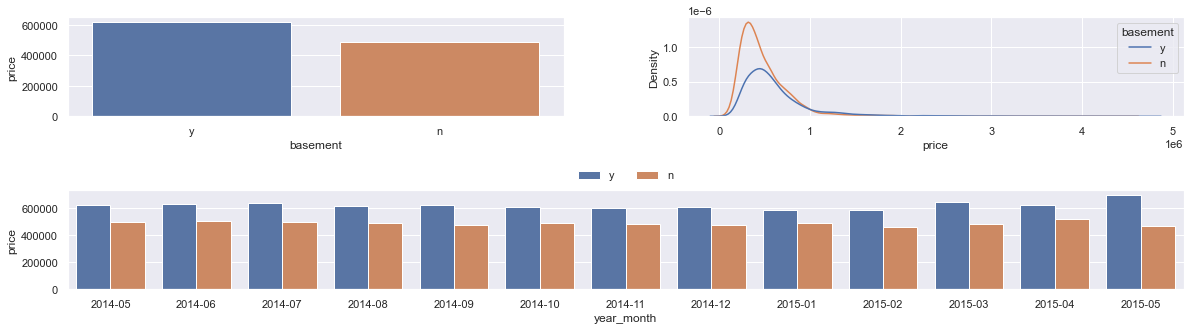

In [77]:
# size fig. parameters
w_size = 20
h_size = 5

# plot separation parameters
w_space = .25
h_space = .75

fig = plt.figure()

# Set matrix size and plot separations
gs = gridspec.GridSpec(2, 2, wspace=w_space, hspace=h_space)

fig.add_subplot(gs[0, 0])
by_yr_m_s = df4[['basement', 'price']].groupby(['basement']).mean().reset_index()
sns.barplot(data=by_yr_m_s, x='basement', y='price', order=['y','n']);

fig.add_subplot(gs[0, 1])
sns.kdeplot( data=df4, x='price', hue='basement', hue_order=['y','n']);

fig.add_subplot(gs[1, :])
by_yr_m_s = df4[['year_month', 'basement', 'price']].groupby(['year_month', 'basement']).mean().reset_index()
ax=sns.barplot(data=by_yr_m_s, x='year_month', y='price', hue='basement', hue_order=['y','n']);
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

# Set figure size
ax.figure.set_size_inches(w_size, h_size)
fig.align_labels()

In [78]:
# com porão
price_bas  = df4.loc[df4['sqft_basement'] != 0, 'price'].mean()

# sem porão
price_bas0 = df4.loc[df4['sqft_basement'] == 0, 'price'].mean()

print(f'Imóveis com porão são {round((price_bas - price_bas0)*100/price_bas0,0)}% mais caros.')
print(f'Percentual de imóveis sem porão com potencial de reforma: {round(df4.loc[df4["sqft_basement"] != 0, "id"].count()*100/df4.shape[0],0)}%.')

Imóveis com porão são 27.0% mais caros.
Percentual de imóveis sem porão com potencial de reforma: 39.0%.


In [79]:
# Criar dataset
by_yr_m_s = df4[['year_month', 'basement', 'price']].groupby(['year_month', 'basement']).mean().reset_index()

# criar variável valorização
by_yr_m_s['diff'] = by_yr_m_s['price'].diff()
by_yr_m_s['appreciation_%'] = 0
for i in range(len(by_yr_m_s)-1):
    by_yr_m_s.loc[i+1, 'appreciation_%'] = by_yr_m_s.loc[i+1, 'diff']*100/by_yr_m_s.loc[i, 'price']

# month vs valorização
by_yr_m_s.loc[by_yr_m_s['appreciation_%'] > 0, ['year_month', 'appreciation_%']]

year_month  appreciation_%
1     2014-05           25.17
3     2014-06           25.14
5     2014-07           29.35
7     2014-08           26.33
9     2014-09           31.02
11    2014-10           23.41
13    2014-11           24.15
15    2014-12           28.02
17    2015-01           19.86
19    2015-02           27.63
21    2015-03           33.51
23    2015-04           20.37
25    2015-05           48.05

In [80]:
# Hipótese falsa. Imóveis com porão são 27% mais caros. Porém, ao longo do tempo a valorização chega a ~48% (maio). 

# Acionáveis:

# 1. Compra imóveis sem porão. São mais baratos.
# 2. Compra imóveis sem porão e faz reforma. Se valorizam 27%.
# 3. Compra imóveis sem porão e faz reforma. Se valorizam 48% se vendidos em maio. 

### Imóveis que possuem vista para água, são 30% mais caros, na média.

***Hipótese verdadeira***

Imóveis que possuem vista para água, são 198% mais caros, na média.

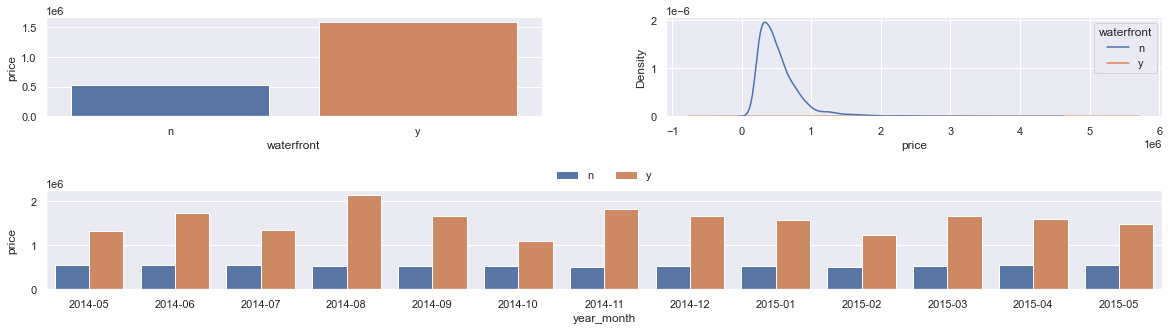

In [81]:
# size fig. parameters
w_size = 20
h_size = 5

# plot separation parameters
w_space = .25
h_space = .75

fig = plt.figure()

# Set matrix size and plot separations
gs = gridspec.GridSpec(2, 2, wspace=w_space, hspace=h_space)

fig.add_subplot(gs[0, 0])
# subplot(1,2,1)
by_wfront = df4[['price','waterfront']].groupby('waterfront').mean().reset_index()
sns.barplot(data=by_wfront, x='waterfront', y='price')

fig.add_subplot(gs[0, 1])
# subplot(1,2,2)
sns.kdeplot( data=df4, x='price', hue='waterfront', hue_order=['n', 'y']);

fig.add_subplot(gs[1, :])
by_yr_m_s = df4[['year_month', 'waterfront', 'price']].groupby(['year_month', 'waterfront']).mean().reset_index()
ax=sns.barplot(data=by_yr_m_s, x='year_month', y='price', hue='waterfront', hue_order=['n', 'y']);
sns.move_legend(
    ax, "lower center",
    bbox_to_anchor=(.5, 1), ncol=3, title=None, frameon=False,
)

# Set figure size
ax.figure.set_size_inches(w_size, h_size)
fig.align_labels()

In [82]:
by_yr_m_s = df4[['year_month', 'waterfront', 'price']].groupby(['year_month', 'waterfront']).mean().reset_index()
var1 = by_yr_m_s.loc[by_yr_m_s['waterfront'] == 'y',['year_month','price']].sort_values('year_month', ascending=True)
var2 = by_yr_m_s.loc[by_yr_m_s['waterfront'] == 'n',['year_month','price']].sort_values('year_month', ascending=True)
merge_var = pd.merge(var1,var2,how='inner',on='year_month')
merge_var.columns = ['year_month','price_y', 'price_n']
merge_var['appre_%'] = merge_var.apply(lambda x: (x['price_y']/x['price_n']-1)*100, axis=1)
merge_var

year_month    price_y   price_n  appre_%
0     2014-05 1318400.00 544830.38   141.98
1     2014-06 1737361.11 546276.40   218.04
2     2014-07 1333926.67 541353.86   146.41
3     2014-08 2135166.67 526890.06   305.24
4     2014-09 1666576.67 519468.54   220.82
5     2014-10 1098366.13 530641.53   106.99
6     2014-11 1827600.00 509088.56   258.99
7     2014-12 1656291.67 516457.09   220.70
8     2015-01 1571875.00 516777.79   204.17
9     2015-02 1239833.33 504739.23   145.64
10    2015-03 1654961.54 535346.63   209.14
11    2015-04 1587941.67 548700.06   189.40
12    2015-05 1483333.33 554376.82   167.57

In [83]:
# preço imóveis com vista para água
price_wfront_1 = df4.loc[df4['waterfront'] == 'y', 'price'].mean()

# preço imóveis sem vista para água
price_wfront_0 = df4.loc[df4['waterfront'] == 'n', 'price'].mean()

print(f'Imóveis com vista para água são {round(((price_wfront_1 - price_wfront_0)*100)/price_wfront_0,0)}% mais caros.')
print(f'Percentual de imóveis com vista para água: {round(df4.loc[df4["waterfront"] == "y","id"].count()*100/df4.shape[0],1)}%.')

Imóveis com vista para água são 198.0% mais caros.
Percentual de imóveis com vista para água: 0.7%.


In [84]:
# Os imóveis com vista para água são mais de duas vezes mais caros que os que não tem vista para água. São muito caros. É uma surpresa, em vista de que, se esperava que fossem um 30% mais caros. Possível insight. 

# imóveis com vista para água tem alta variabilidade ao longo do tempo. Calcular a diferença percentual mes-a-mes. Tem meses em que o preço dos imóveis com vista para água chega a ser até 4 vezes maior.

# Acionáveis: 

# 1. Comprar imóveis sem vista para água. 
# 2. Compra aqueles que estão abaixo da média (mediana) dessa região e vende com um fator de lucro maior. Isto último em vista da grande diferença de preços entre os imóveis com e sem vista para água. 

# 3.0. PRINCIPAIS INSIGHTS 

1. Os imóveis mais novos que estão em boas condições deveriam ser 30% mais caros, na média, que os imóveis antigos em condições  regulares. (*hipótese verdadeira*)
2. Imóveis novos e em boas condições são 70% mais ofertados que imóveis antigos e em condições regulares. (*hipótese falsa*)
3. Imóveis de 3 quartos com reforma para ter mais um, se valorizam em 30%, na média. (*hipótese verdadeira*)
4. Imóveis próximos do centro da cidade deveriam ser um 30% mais caros, na média, dos que estão mais afastados. (*Hipótese verdadeira*)
5. Imóveis com porão são 40% mais caros, na média, do que os imóveis sem porão. (*Hipótese falsa*)

# 4.0. QUESTÕES DE NEGÓCIO E POSSÍVEIS SOLUÇÕES

In [85]:
df5 = df4.copy()

##  4.1. Quais são os imóveis que a House Rocket deveria comprar e por qual preço?

In [86]:
# criar variável mediana do preço por região
df5 = get_price_median(df5, 'price_median', ['zipcode'])

# criar variável de recomendação
df5['advise'] = df5.apply(lambda x: 'buy' if (x['price'] < x['price_median']) & (x['cond_type'] == 'good') else 'not_buy', axis=1)
    
print(f'Imóveis sugeridos: {df5[df5["advise"] == "buy"].shape[0]}.')
print(f'Percentual de imóveis sugeridos para compra: {df5[df5["advise"] == "buy"].shape[0]*100/df5.shape[0]:.0f}%')

Imóveis sugeridos: 3783.
Percentual de imóveis sugeridos para compra: 18%


### 4.1.1. Relatório 01

In [87]:
# ---------------------------------
# Relatório 01: sugestões de compra
# ---------------------------------

# selecionar colunas
cols = ['id', 
        'zipcode', 
        'price',
        'price_median', 
        'cond_type', 
        'advise']

# criar dataset
dfr1 = report(df5, cols)
dfr1.head()

# # exportar dataset
# dfr1.to_csv('report_01.csv', index=False)

id  zipcode  price_buy  price_median cond_type   advise
0  7129300520    98178  221900.00     279500.00   regular  not_buy
1  4060000240    98178  205425.00     279500.00      good      buy
2  4058801670    98178  445000.00     279500.00   regular  not_buy
3  2976800796    98178  236000.00     279500.00   regular  not_buy
4  6874200960    98178  170000.00     279500.00   regular  not_buy

## 4.2. Uma vez a casa comprada, qual o melhor momento para vendê-la e por qual preço?

In [88]:
# criar dataset com sugestões de compra
df_buy = get_adv(df5, 'buy')

In [89]:
# criar variável sazonalidade
df_buy = get_seas(df_buy)

# criar variável mediana do preço por região e sazonalidade 
df_buy = get_price_median(df_buy, 'price_median_zs', ['zipcode', 'seasonality'])

# fator de lucro mínimo
f_min = .1 

# fator de lucro máximo
f_max = .3  

# lucro por revenda
df_buy['gain_resale'] = df_buy.apply(lambda x: f_max * x['price'] if (x['price'] <  x['price_median_zs']) else f_min * x['price'], axis=1)

# criar variável data de venda
df_buy = get_date_sale(df_buy)

print(f'Percentual de lucro por revenda: {df_buy["gain_resale"].sum()*100/df_buy["price"].sum():.1f}%.')

Percentual de lucro por revenda: 18.4%.


### 4.2.1. Lucro por Vista para Água

In [90]:
# preço do mercado dos imóveis
price_wfront = df4.loc[df4['waterfront'] == 'y', 'price'].mean()

# fator de lucro
f_wfront = 1.98

# lucro por vista para água
df_buy['gain_wfront'] = df_buy.apply(lambda x: f_wfront * x['price'] if (x['waterfront'] == "y") & (x['price'] < price_wfront) else 0, axis=1)

### 4.2.2. Lucro por Localização

In [91]:
# raio do centro da cidade
rad_center_city = 5 # km

# fator de lucro
f_center = .46

# preço do mercado dos imóveis
price_center = df_buy.loc[df_buy['distance_km'] <= rad_center_city, 'price'].mean()

# lucro do imóvel
df_buy['gain_loc'] = df_buy.apply(lambda x: f_center * x['price'] if (x['distance_km'] <= rad_center_city) & (x['price'] < price_center) else 0, axis=1)

### 4.2.3. Lucro Total

In [92]:
# lucro total
df_buy['gain_tot'] = df_buy['gain_resale'] + df_buy['gain_wfront'] + df_buy['gain_loc']

# preço de venda
df_buy['price_sale'] = df_buy['price'] + df_buy['gain_tot']

print(f'Percentual de lucro por vista para água: {df_buy["gain_wfront"].sum()*100/df_buy["price"].sum():.1f}%.')
print(f'Percentual de lucro por localização: {df_buy["gain_loc"].sum()*100/df_buy["price"].sum():.1f}%.')
print(f'Percentual de lucro por revenda: {df_buy["gain_resale"].sum()*100/df_buy["price"].sum():.1f}%.', end='\n\n')
print(f'Percentual de lucro total: {df_buy["gain_tot"].sum()*100/df_buy["price"].sum():.1f}%.')

Percentual de lucro por vista para água: 0.2%.
Percentual de lucro por localização: 0.8%.
Percentual de lucro por revenda: 18.4%.

Percentual de lucro total: 19.4%.


id       date  year     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  house_age cond_type house_quality  distance_km level year_month basement dormitory_type  price_median seasonality  price_median_zs  gain_resale date_sale  gain_wfront  gain_loc  gain_tot  price_sale
0  4060000240 2014-06-23  2014 205425.00         2       1.00          880      6780    1.00          n     0          4      6         880              0      1945             0    98178 47.50 -122.25           1190        6780  house_old      good           avg        13.31   low    2014-06        n      apartment     279500.00      summer        230000.00     61627.50    winter         0.00      0.00  61627.50   267052.50
1  8068000585 2014-08-27  2014 235000.00         2       1.00          880      5600    1.00          n     0          5      7         880              0      1955             0    98178 47.51 -122.27           1240        7015  house_old      good           avg        12.12   low    2014-08        n      apartment     279500.00      summer        230000.00     23500.00    summer         0.00      0.00  23500.00   258500.00
2  1180008315 2014-07-15  2014 212000.00         3       1.00         1040      6800    1.00          n     0          5      6        1040              0      1951             0    98178 47.49 -122.22           1430        6080  house_old      good           avg        15.08   low    2014-07        n          house     279500.00      summer        230000.00     63600.00    winter         0.00      0.00  63600.00   275600.00
3  1180007005 2014-06-25  2014 265950.00         3       1.50         1150      8450    1.00          n     0          4      6        1150              0      1951             0    98178 47.49 -122.22           1160        6800  house_old      good           avg        15.01   low    2014-06        n          house     279500.00      summer        230000.00     26595.00    summer         0.00      0.00  26595.00   292545.00
4  4058801065 2014-08-08  2014 272000.00         3       2.00         1200      5700    1.00          n     0          5      7        1200              0      1942             0    98178 47.50 -122.24           1190        6384  house_old      good           avg        13.32   low    2014-08        n          house     279500.00      summer        230000.00     27200.00    summer         0.00      0.00  27200.00   299200.00

### 4.2.4. Relatório 02

In [93]:
# --------------------------------
# Relatório 02: sugestões de venda
# --------------------------------

# selecionar colunas
cols = ['id', 
        'zipcode', 
        'seasonality',
        'price_median_zs',
        'price',
        'gain_tot',
        'price_sale',
        'date_sale']

# criar dataset
dfr2 = report(df_buy, cols)
dfr2.head()

# # exportar dataset
# dfr2.to_csv('report_02.csv', index=False)

id  zipcode seasonality  price_median_zs  price_buy  gain_tot  price_sale date_sale
0  4060000240    98178      summer        230000.00  205425.00  61627.50   267052.50    winter
1  8068000585    98178      summer        230000.00  235000.00  23500.00   258500.00    summer
2  1180008315    98178      summer        230000.00  212000.00  63600.00   275600.00    winter
3  1180007005    98178      summer        230000.00  265950.00  26595.00   292545.00    summer
4  4058801065    98178      summer        230000.00  272000.00  27200.00   299200.00    summer

## 4.3. A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?

In [94]:
df5 = df4.copy()

In [95]:
# criar variável mediana do preço por região 
df5 = get_price_median(df5, 'price_median', ['zipcode'])

# criar variável de recomendação
df5['advise'] = df5.apply(lambda x: 'buy' if (x['price'] < x['price_median']) & ((x['cond_type'] == 'good') | (x['cond_type'] == 'regular')) else 'not_buy', axis=1)

print(f'Imóveis sugeridos: {df5[df5["advise"] == "buy"].shape[0]}.')
print(f'Percentual de imóveis sugeridos para compra: {df5[df5["advise"] == "buy"].shape[0]*100/df5.shape[0]:.0f}%')

Imóveis sugeridos: 10498.
Percentual de imóveis sugeridos para compra: 49%


In [96]:
# criar dataset com sugestões de compra
df_buy = get_adv(df5, 'buy')

### 4.3.1. Lucro por localização

In [97]:
# raio do centro da cidade
rad_center_city = 5 # km

# fator de lucro
f_center = .46

# preço do mercado dos imóveis
price_center = df_buy.loc[df_buy['distance_km'] <= rad_center_city, 'price'].mean()

# lucro do imóvel
df_buy['gain_loc'] = df_buy.apply(lambda x: f_center * x['price'] if (x['distance_km'] <= rad_center_city) & (x['price'] < price_center) else 0, axis=1)

### 4.3.2. Lucro por vista para água

In [98]:
# Preço do mercado imóveis
price_wfront = df4.loc[df4['waterfront'] == 'y', 'price'].mean()

# Fator de ganho 
f_wfront = 1.98

# Lucro de um imóvel
df_buy['gain_wfront'] = df_buy.apply(lambda x: f_wfront * x['price'] if (x['waterfront'] == 'y') & (x['price'] < price_wfront) else 0, axis=1)

### 4.3.3. Lucro por reformas de condição e idade

In [99]:
# Preço do mercado imóveis
price_cond_age = df4.loc[(df4['house_age'] == 'house_new') & (df4['cond_type'] == 'good'), 'price'].mean()

# Fator de lucro: house_old_reg > house_new_good
f_old_reg  = .60 
# OBS: Assumindo que todo o que se valoriza vai como lucro. Na hipótese a valorização é de .60

# Fator de lucro: house_old_good > house_new_good
f_old_good = .41 
# OBS: Assumindo que todo o que se valoriza vai como lucro. Na hipótese a valorização é de .41

# Fator de lucro: house_new_reg > house_new_good
f_new_reg  = .21 
# OBS: Assumindo que todo o que se valoriza vai como lucro. Na hipótese a valorização é de .21

# Lucro por condição e idade
df_buy['gain_cond_age'] = df_buy.apply(lambda x: f_old_reg  * x['price'] if (x['house_age'] == 'house_old') & (x['cond_type'] == 'regular') & (x['price'] < price_cond_age) else
                                                 f_old_good * x['price'] if (x['house_age'] == 'house_old') & (x['cond_type'] == 'good')    & (x['price'] < price_cond_age) else 
                                                 f_new_reg  * x['price'] if (x['house_age'] == 'house_new') & (x['cond_type'] == 'regular') & (x['price'] < price_cond_age) else 0, axis=1)

### 4.3.4. Lucro por revenda

In [100]:
# Criar variável sazonalidade
df_buy = get_seas(df_buy)

# Criar variável mediana do preço por região e sazonalidade 
df_buy = get_price_median(df_buy, 'price_median_zs', ['zipcode', 'seasonality'])

# Fator de lucro por revenda de imóveis caros
f_min = .1

# Fator de lucro por revenda de imóveis baratos
f_max = .3

# Lucro por revenda
df_buy['gain_resale'] = df_buy.apply(lambda x: f_max * (x['price'] + x['gain_cond_age']) if (x['price'] <  x['price_median_zs']) else f_min * (x['price'] + x['gain_cond_age']), axis=1)

# OBS:

# 1. Supondo que todos os imóveis ficaram como novos e em boas condições.

# 2. Se o preço de compra está ABAIXO da mediana, o imóvel (nessa região e sazonalidade) é mais BARATO. Logo, tenho uma MAIOR manobrabilidade no preço de venda. Vou supor um preço de venda de 30% acima do preço de compra (f_max * x['price']). 

# 3. Se o preço de compra está ACIMA da mediana, o imóvel (nessa região e sazonalidade) é mais CARO. Logo, tenho uma MENOR manobrabilidade para o preço de venda. Vou supor um preço de venda de 10% acima do preço de compra (f_min * x['price']). Se o preço de compra for IGUAL à mediana vou considerar que o imóvel é CARO.

# Criar variável data de venda
df_buy = get_date_sale(df_buy)

### 4.3.5. Lucro por reformas de porão

In [101]:
# Preço do mercado
price_bas = df4.loc[df4['sqft_basement'] != 0, 'price'].mean()

# Fator de lucro
f_bas = .27 
# OBS: Assumindo que todo o que se valoriza vai como lucro. Na hipótese a valorização é de .27

# Lucro pela reforma
df_buy['gain_bas'] = df_buy.apply(lambda x: f_bas * x['price'] if (x['sqft_basement'] == 0) & (x['dormitory_type'] == 'house') else 0, axis=1) 

### 4.3.6. Lucro por reforma de quartos

In [102]:
# Tipos de imóveis por quantidade de quartos
list_bed = [1, 2, 3, 4, 6]

# Lucros para list_bed
list_gain = [.2503, .1647, .3593, .2220, .2303]
        
# Deletar coluna gain_bed
if 'gain_bed' in df_buy.columns.to_list():
    df_buy.drop('gain_bed', axis=1, inplace=True)

# Adicionar lucros    
for ind in range(len(list_bed)):

    # lucro pela reforma
    df_buy = get_gain_bed(df_buy, list_bed[ind], list_gain[ind])

Percentual de imóveis com 1 quartos reformados para ter 2: 30.5%
Percentual de lucro: 0.084%

Percentual de imóveis com 2 quartos reformados para ter 3: 36.6%
Percentual de lucro: 1.140%

Percentual de imóveis com 3 quartos reformados para ter 4: 27.7%
Percentual de lucro: 5.283%

Percentual de imóveis com 4 quartos reformados para ter 5: 0.0%
Percentual de lucro: 0.000%

Percentual de imóveis com 6 quartos reformados para ter 7: 33.3%
Percentual de lucro: 0.040%



### 4.3.7. Lucro total

In [106]:
# Lucro total
df_buy['gain_tot'] = df_buy['gain_cond_age'] + df_buy['gain_resale'] + df_buy['gain_bas'] + df_buy['gain_loc'] + df_buy['gain_wfront'] + df_buy['gain_bed']

# Preço de venda
df_buy['price_sale'] = df_buy['price'] + df_buy['gain_tot']

print(f'Percentual de lucro por vista para água: {df_buy["gain_wfront"].sum()*100/df_buy["price"].sum():.1f}%.')
print(f'Percentual de lucro por localização: {df_buy["gain_loc"].sum()*100/df_buy["price"].sum():.1f}%.')
print(f'Percentual de lucro por reforma de quartos: {df_buy["gain_bed"].sum()*100/df_buy["price"].sum():.0f}%.')
print(f'Percentual de lucro por reforma de porão: {df_buy["gain_bas"].sum()*100/df_buy["price"].sum():.0f}%.')
print(f'Percentual de lucro por revenda: {df_buy["gain_resale"].sum()*100/df_buy["price"].sum():.0f}%.')
print(f'Percentual de lucro por condição e idade: {df_buy["gain_cond_age"].sum()*100/df_buy["price"].sum():.0f}%.', end='\n\n')
print(f'Percentual de lucro total: {df_buy["gain_tot"].sum()*100/df_buy["price"].sum():.0f}%.')
df_buy.head()

Percentual de lucro por vista para água: 0.2%.
Percentual de lucro por localização: 1.5%.
Percentual de lucro por reforma de quartos: 7%.
Percentual de lucro por reforma de porão: 13%.
Percentual de lucro por revenda: 26%.
Percentual de lucro por condição e idade: 42%.

Percentual de lucro total: 89%.


id       date  year     price  bedrooms  bathrooms  sqft_living  sqft_lot  floors waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  zipcode   lat    long  sqft_living15  sqft_lot15  house_age cond_type house_quality  distance_km level year_month basement dormitory_type  price_median  gain_loc  gain_wfront  gain_cond_age seasonality  price_median_zs  gain_resale date_sale  gain_bas  gain_bed  gain_tot  price_sale
0  7129300520 2014-10-13  2014 221900.00         3       1.00         1180      5650    1.00          n     0          3      7        1180              0      1955             0    98178 47.51 -122.26           1340        5650  house_old   regular           avg        11.98   low    2014-10        n          house     279500.00      0.00         0.00      133140.00        fall        216500.00     35504.00    summer  59913.00      0.00 228557.00   450457.00
1  2976800796 2014-09-25  2014 236000.00         3       1.00         1300      5898    1.00          n     0          3      7        1300              0      1961             0    98178 47.51 -122.25           1320        7619  house_old   regular           avg        12.63   low    2014-09        n          house     279500.00      0.00         0.00      141600.00        fall        216500.00     37760.00    summer  63720.00      0.00 243080.00   479080.00
2  1180003090 2014-09-06  2014 190000.00         2       1.00          630      6000    1.00          n     0          3      6         630              0      1943          2005    98178 47.50 -122.22           1470        6840  house_new   regular           avg        14.71   low    2014-09        n      apartment     279500.00      0.00         0.00       39900.00        fall        216500.00     68970.00    winter      0.00      0.00 108870.00   298870.00
3   179000350 2014-11-05  2014 194000.00         3       1.50         1010      5000    1.00          n     0          3      6        1010              0      1943             0    98178 47.49 -122.28            980        5000  house_old   regular           avg        13.28   low    2014-11        n          house     279500.00      0.00         0.00      116400.00        fall        216500.00     93120.00    summer  52380.00      0.00 261900.00   455900.00
4  3810000202 2014-09-05  2014 251700.00         3       2.25         1810     11800    1.00          n     0          3      7        1240            570      1977             0    98178 47.50 -122.23           1810        5641  house_old   regular           avg        14.07   low    2014-09        y          house     279500.00      0.00         0.00      151020.00        fall        216500.00     40272.00    summer      0.00      0.00 191292.00   442992.00

### 4.3.8. Relatório 03

## 4.4. Dos imóveis comprados quantos e quais a House Rocket vender, como mínimo, para o projeto se pagar?

In [104]:
df_min = get_inv_rec(df_buy, 'min', 'price', 'price_sale')

--------------------------
Recomendação imóveis min.:
-------------------------- 

Imóveis para venda: 10498
Imóveis min.: 3976.
Percentual: 38%. 

Investimento: 4073433244
Vendas min.: 4073543871
Percentual de lucro: 0.003% 



### 4.4.1. Relatório 04

In [105]:
# --------------------------------
# Relatório 03: sugestões de venda
# --------------------------------

# Selecionar colunas de interesse
cols = ['id', 
        'zipcode', 
        'price_sale',
        'date_sale']

# Criar dataset
dfr3 = report(df_min, cols)
dfr3.head()

# # Exportar dataset
# dfr3.to_csv('report_03.csv', index=False)

id  zipcode  price_sale date_sale
0  2525049266    98039  2413940.00    summer
1  3025300250    98039  2219400.00    summer
2  3262300235    98039  2130350.00    winter
3  3262300818    98039  2051500.00    summer
4  3025300225    98039  1986500.00    winter